In [206]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

In [207]:
# Load Vehicle and Non-Vehicle images
cars = []
notcars = []

images = glob.glob("vehicles/*/*")
for img in images:
    cars.append(img)

images = glob.glob("non-vehicles/*/*")
for img in images:
    notcars.append(img)

In [208]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [209]:
data_info = data_look(cars, notcars)

In [210]:
print('Function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

Function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


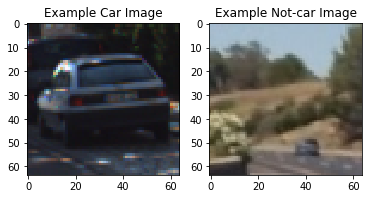

In [211]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [212]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        
        return features, hog_image
    else:      
        
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)
        return features

In [213]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

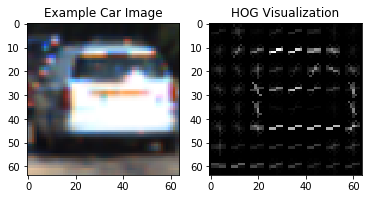

In [214]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [215]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [216]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [217]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [218]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [219]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [220]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [221]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [222]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [223]:
ystart = 400
ystop = 720
scale = 1.5
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]


t=time.time()
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
print ('colorspace:',color_space, 'orient:', orient, 'pix_per_cell:', pix_per_cell, 'cell_per_block:', cell_per_block )

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


3.1 Seconds to extract HOG features...
colorspace: YUV orient: 11 pix_per_cell: 16 cell_per_block: 2


In [224]:

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
#print('Test vector length:', len(X_test[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  0.]
0.00226 Seconds to predict 10 labels with SVC


In [225]:
image = cv2.imread('test_images/test1.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

#windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))

windows = []

windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 580], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))


hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

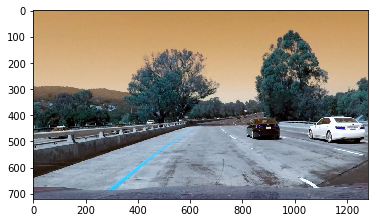

In [226]:
plt.imshow(window_img)

In [227]:
image = cv2.imread('test_images/test1.jpg')
image = image.astype(np.float32)/255

scales = [(40,40), (60,60), (90,90), (120,120), (170,170)]
overlaps = [0.25, 0.25, 0.5, 0.75, 0.75]
y_stops = [500, 550, 600, 600, None]
x_start_stops = [[400,850], [360,890], [320,930], [None, None], [None, None]]
colors = [(0,255,0), (255,0,0), (128,128,0), (0,128,128), (128,0,128)]

In [228]:
multi_window_img = np.copy(image)
for scale, overlap, color, y_stop, x_start_stop in zip(scales, overlaps, colors, y_stops, x_start_stops):
        
    windows = slide_window(multi_window_img, x_start_stop=x_start_stop, y_start_stop=[380,y_stop],
                               xy_window=scale, xy_overlap=(overlap, overlap))
    
    multi_window_img = draw_boxes(multi_window_img, windows, color=color, thick=2) 

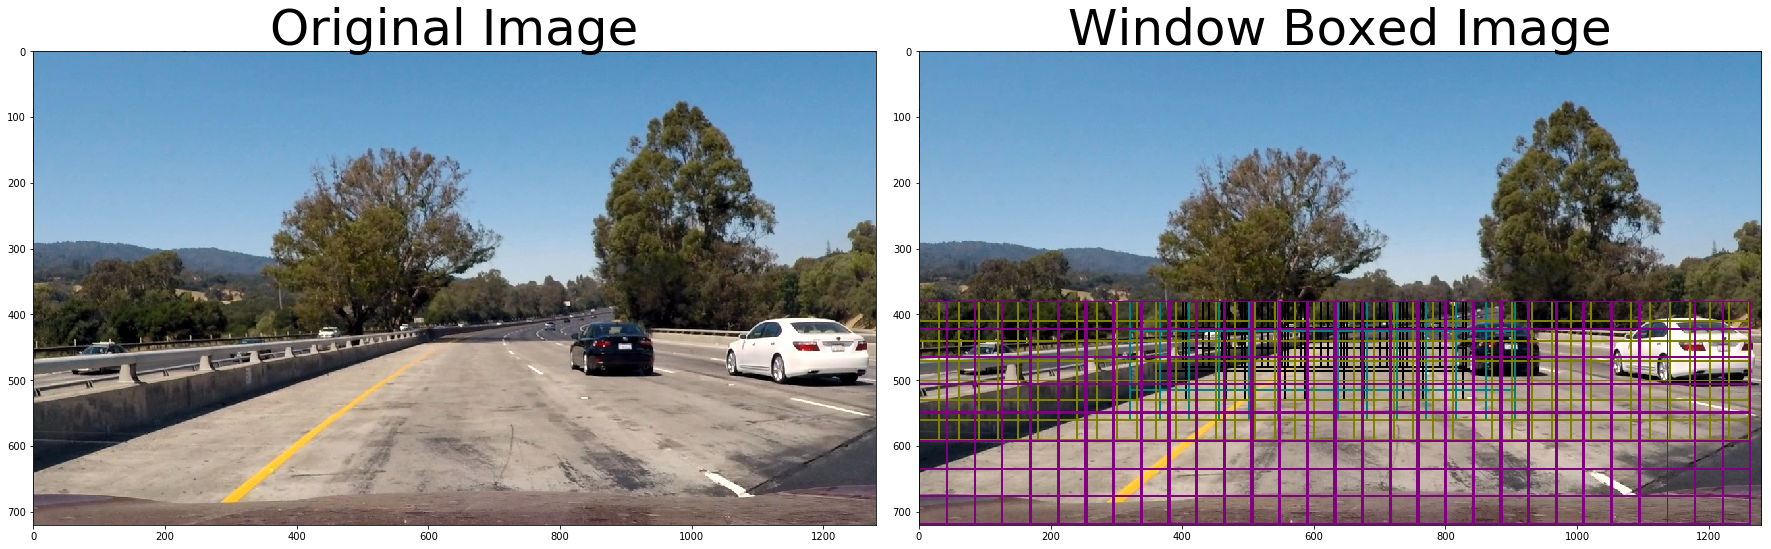

In [229]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(multi_window_img, cv2.COLOR_BGR2RGB), cmap='gray')
ax2.set_title('Window Boxed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [230]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size=False, hist_bins=False):
    
    draw_img = np.copy(img)
    #draw_img = draw_img.astype(np.float32)/255
    
    img_tosearch = draw_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    #print("TEST")
    #print(hog_channel)
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else :
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else :
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((False, False)).reshape(1, -1))  
            test_prediction = svc.predict(hog_features)
            
        
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
    return  bbox_list

In [231]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print (box)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [232]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [233]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [234]:
def draw_boxes(img, bboxes, color=(255,0,0), thick=6, random_color=False):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Random color code copied from jeremy-shannon
        if random_color == True:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [235]:

test_img = mpimg.imread('./test_images/test1.jpg')

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bbox_list = []

ystart = 400
ystop = 720
scale = 1.0
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 400
ystop = 500
scale = 1.5
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 400
ystop = 720
scale = 2.0
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 464
ystop = 660
scale = 3.5
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)


In [236]:
#Old base dont change
test_img = mpimg.imread('./test_images/test6.jpg')

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bbox_list = []

ystart = 400
ystop = 500
scale = 1.0
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 360
ystop = 550
scale = 1.5
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 320
ystop = 600
scale = 2.0
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 300
ystop = 650
scale = 3.5
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)
#Old base dont change

In [278]:

test_img = mpimg.imread('./test_images/test5.jpg')

#test_img = mpimg.imread('./test/18.jpg')

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

bbox_list = []

ystart = 400
ystop = 490
scale = 1.0
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 410
ystop = 500
scale = 1.125
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 400
ystop = 500
scale = 1.25
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 400
ystop = 500
scale = 1.75
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 360
ystop = 550
scale = 1.5
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 320
ystop = 600
scale = 2.0
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

ystart = 300
ystop = 650
scale = 3.5
bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)


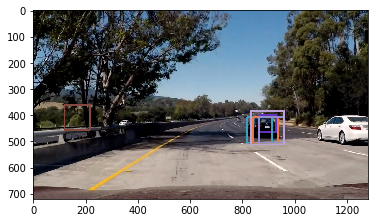

In [279]:
out_img = draw_boxes(test_img, bbox_list, random_color=True)
#print (bbox_list)
#print (len(bbox_list))
plt.imshow(out_img)

((864, 400), (928, 464))
((120, 360), (216, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))


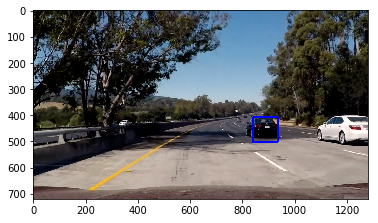

In [280]:

heat_img = np.copy(test_img)
heat = np.zeros_like(heat_img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,bbox_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
plt.imshow(draw_img)

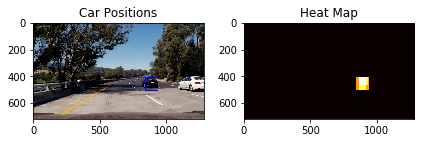

In [281]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

1 Cars found


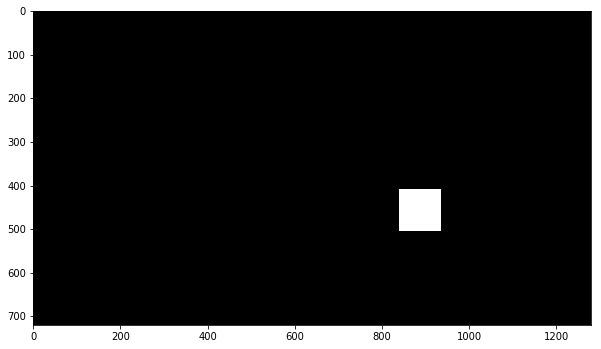

In [282]:
labels = label(heatmap)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'Cars found')

In [283]:
def process_image_new(img):
    
    test_img = np.copy(img)  
    
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    bbox_list = []

    ystart = 400
    ystop = 500
    scale = 1.0
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 360
    ystop = 550
    scale = 1.5
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 320
    ystop = 600
    scale = 2.0
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 300
    ystop = 650
    scale = 3.5
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    heat_img = np.copy(test_img)
    heat = np.zeros_like(heat_img[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    return draw_img

In [284]:
def process_image(img) :
    
    test_img = np.copy(img)  
    
    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' 

    bbox_list = []

    ystart = 400
    ystop = 464
    scale = 1.0
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 416
    ystop = 480
    scale = 1.0
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 400
    ystop = 496
    scale = 1.5
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 432
    ystop = 528
    scale = 1.5
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)
    
    ystart = 400
    ystop = 720
    scale = 3.5
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    
    heat_img = np.copy(test_img)
    heat = np.zeros_like(heat_img[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    return draw_img

In [285]:
def process_image_latest(img) :
    
    test_img = np.copy(img)  
    
    colorspace = 'YUV' 
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' 
    
    bbox_list = []
    
    ystart = 400
    ystop = 490
    scale = 1.0
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 410
    ystop = 500
    scale = 1.125
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 400
    ystop = 500
    scale = 1.25
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)
    
    ystart = 400
    ystop = 500
    scale = 1.75
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 360
    ystop = 550
    scale = 1.5
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 320
    ystop = 600
    scale = 2.0
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

    ystart = 300
    ystop = 650
    scale = 3.5
    bbox_list += find_cars(test_img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, hog_channel)

 
    heat_img = np.copy(test_img)
    heat = np.zeros_like(heat_img[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    return draw_img

((864, 400), (928, 464))
((120, 360), (216, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))


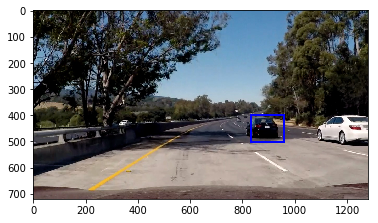

In [286]:
test_img = mpimg.imread('./test_images/test5.jpg')
plt.imshow(process_image_latest(test_img))

In [292]:
from moviepy.editor import VideoFileClip
# Function to read the video file from repository
# Generate the pipeline video file

clip = VideoFileClip("test_video.mp4")
video_out = "test_video_out5.mp4"

video_cap = clip.fl_image(process_image_latest)
%time video_cap.write_videofile(video_out, audio=False)

((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
[MoviePy] >>>> Building video test_video_out5.mp4
[MoviePy] Writing video test_video_out5.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:14,  2.56it/s]

((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))




  5%|▌         | 2/39 [00:00<00:14,  2.56it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




  8%|▊         | 3/39 [00:01<00:14,  2.55it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 10%|█         | 4/39 [00:01<00:13,  2.56it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 13%|█▎        | 5/39 [00:01<00:13,  2.56it/s]

((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 15%|█▌        | 6/39 [00:02<00:13,  2.54it/s]

((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 18%|█▊        | 7/39 [00:02<00:12,  2.53it/s]

((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 360), (1176, 456))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 21%|██        | 8/39 [00:03<00:12,  2.54it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 23%|██▎       | 9/39 [00:03<00:11,  2.55it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 26%|██▌       | 10/39 [00:03<00:11,  2.54it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 360), (1176, 456))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 28%|██▊       | 11/39 [00:04<00:10,  2.55it/s]

((128, 400), (192, 464))
((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((160, 416), (288, 544))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 31%|███       | 12/39 [00:04<00:10,  2.55it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((128, 416), (256, 544))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 33%|███▎      | 13/39 [00:05<00:10,  2.57it/s]

((1088, 400), (1152, 464))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 36%|███▌      | 14/39 [00:05<00:09,  2.59it/s]

((864, 410), (936, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 360), (1200, 456))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 38%|███▊      | 15/39 [00:05<00:09,  2.62it/s]

((1136, 400), (1200, 464))
((864, 410), (936, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 41%|████      | 16/39 [00:06<00:08,  2.61it/s]

((864, 410), (936, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 44%|████▎     | 17/39 [00:06<00:08,  2.59it/s]

((864, 410), (936, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1188, 410), (1260, 482))
((60, 400), (140, 480))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 46%|████▌     | 18/39 [00:07<00:08,  2.59it/s]

((16, 400), (80, 464))
((112, 400), (176, 464))
((864, 410), (936, 482))
((1098, 410), (1170, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((608, 416), (736, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 49%|████▊     | 19/39 [00:07<00:07,  2.61it/s]

((1098, 410), (1170, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((576, 416), (704, 544))
((608, 416), (736, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 51%|█████▏    | 20/39 [00:07<00:07,  2.62it/s]

((1104, 400), (1168, 464))
((864, 410), (936, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 54%|█████▍    | 21/39 [00:08<00:06,  2.63it/s]

((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 56%|█████▋    | 22/39 [00:08<00:06,  2.62it/s]

((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 59%|█████▉    | 23/39 [00:08<00:06,  2.65it/s]

((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 62%|██████▏   | 24/39 [00:09<00:05,  2.56it/s]

((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 64%|██████▍   | 25/39 [00:09<00:05,  2.56it/s]

((1152, 400), (1216, 464))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 67%|██████▋   | 26/39 [00:10<00:05,  2.54it/s]

((1116, 410), (1188, 482))
((1152, 410), (1224, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 69%|██████▉   | 27/39 [00:10<00:04,  2.52it/s]

((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))




 72%|███████▏  | 28/39 [00:10<00:04,  2.54it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((624, 408), (720, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 74%|███████▍  | 29/39 [00:11<00:03,  2.54it/s]

((1120, 400), (1184, 464))
((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1170, 410), (1242, 482))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 77%|███████▋  | 30/39 [00:11<00:03,  2.54it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1170, 410), (1242, 482))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 31/39 [00:12<00:03,  2.52it/s]

((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))




 82%|████████▏ | 32/39 [00:12<00:02,  2.49it/s]

((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1170, 410), (1242, 482))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))




 85%|████████▍ | 33/39 [00:12<00:02,  2.48it/s]

((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))




 87%|████████▋ | 34/39 [00:13<00:02,  2.50it/s]

((234, 410), (306, 482))
((1134, 410), (1206, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))




 90%|████████▉ | 35/39 [00:13<00:01,  2.52it/s]

((216, 410), (288, 482))
((1134, 410), (1206, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 92%|█████████▏| 36/39 [00:14<00:01,  2.50it/s]

((1134, 410), (1206, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 95%|█████████▍| 37/39 [00:14<00:00,  2.50it/s]

((1136, 400), (1200, 464))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 97%|█████████▋| 38/39 [00:14<00:00,  2.53it/s]

((1136, 400), (1200, 464))
((1134, 410), (1206, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out5.mp4 

CPU times: user 15 s, sys: 937 ms, total: 15.9 s
Wall time: 15.9 s


In [293]:
from moviepy.editor import VideoFileClip
# Function to read the video file from repository
# Generate the pipeline video file

clip = VideoFileClip("project_video.mp4")
video_out = "project_video_out.mp4"

video_cap = clip.fl_image(process_image_latest)
%time video_cap.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<08:16,  2.54it/s]

  0%|          | 2/1261 [00:00<08:15,  2.54it/s]

  0%|          | 3/1261 [00:01<08:12,  2.56it/s]

((96, 400), (160, 464))




  0%|          | 4/1261 [00:01<08:15,  2.54it/s]

((48, 384), (144, 480))




  0%|          | 5/1261 [00:01<08:14,  2.54it/s]

  0%|          | 6/1261 [00:02<08:10,  2.56it/s]

((256, 320), (384, 448))




  1%|          | 7/1261 [00:02<08:09,  2.56it/s]

((264, 360), (360, 456))
((256, 320), (384, 448))




  1%|          | 8/1261 [00:03<08:05,  2.58it/s]

((264, 360), (360, 456))




  1%|          | 9/1261 [00:03<08:00,  2.61it/s]

  1%|          | 10/1261 [00:03<08:00,  2.60it/s]

  1%|          | 11/1261 [00:04<07:58,  2.61it/s]

  1%|          | 12/1261 [00:04<07:59,  2.60it/s]

  1%|          | 13/1261 [00:05<08:09,  2.55it/s]

  1%|          | 14/1261 [00:05<08:16,  2.51it/s]

  1%|          | 15/1261 [00:05<08:10,  2.54it/s]

  1%|▏         | 16/1261 [00:06<08:09,  2.55it/s]

  1%|▏         | 17/1261 [00:06<08:03,  2.58it/s]

  1%|▏         | 18/1261 [00:07<07:59,  2.59it/s]

  2%|▏         | 19/1261 [00:07<07:51,  2.64it/s]

  2%|▏         | 20/1261 [00:07<07:42,  2.68it/s]

  2%|▏         | 21/1261 [00:08<07:37,  2.71it/s]

  2%|▏         | 22/1261 [00:08<07:47,  2.65it/s]

  2%|▏         | 23/1261 [00:08<07:40,  2.69it/s]

  2%|▏         | 24/1261 [00:09<07:36,  2.71it/s]

  2%|▏         | 25/1261 [00:09<07:39,  2.69it/s]

  2%|▏         | 26/1261 [00:09<07:41,  2.68it/s]

  2%|▏         | 27/1261 [00:10<07:37,  2.69it/s]

((240, 360), (336, 456))




  2%|▏         | 28/1261 [00:10<07:45,  2.65it/s]

  2%|▏         | 29/1261 [00:11<07:46,  2.64it/s]

((1024, 400), (1088, 464))




  2%|▏         | 30/1261 [00:11<07:49,  2.62it/s]

((1024, 400), (1088, 464))




  2%|▏         | 31/1261 [00:11<07:42,  2.66it/s]

  3%|▎         | 32/1261 [00:12<07:40,  2.67it/s]

  3%|▎         | 33/1261 [00:12<07:40,  2.66it/s]

  3%|▎         | 34/1261 [00:12<07:43,  2.64it/s]

  3%|▎         | 35/1261 [00:13<07:41,  2.66it/s]

  3%|▎         | 36/1261 [00:13<07:48,  2.61it/s]

  3%|▎         | 37/1261 [00:14<07:40,  2.66it/s]

  3%|▎         | 38/1261 [00:14<07:36,  2.68it/s]

  3%|▎         | 39/1261 [00:14<07:38,  2.66it/s]

  3%|▎         | 40/1261 [00:15<07:42,  2.64it/s]

  3%|▎         | 41/1261 [00:15<07:41,  2.64it/s]

  3%|▎         | 42/1261 [00:16<07:42,  2.63it/s]

  3%|▎         | 43/1261 [00:16<07:51,  2.58it/s]

((1136, 400), (1200, 464))




  3%|▎         | 44/1261 [00:16<07:47,  2.60it/s]

  4%|▎         | 45/1261 [00:17<07:43,  2.62it/s]

  4%|▎         | 46/1261 [00:17<07:38,  2.65it/s]

  4%|▎         | 47/1261 [00:17<07:35,  2.66it/s]

  4%|▍         | 48/1261 [00:18<07:29,  2.70it/s]

  4%|▍         | 49/1261 [00:18<07:27,  2.71it/s]

  4%|▍         | 50/1261 [00:18<07:26,  2.71it/s]

  4%|▍         | 51/1261 [00:19<07:34,  2.66it/s]

  4%|▍         | 52/1261 [00:19<07:37,  2.64it/s]

  4%|▍         | 53/1261 [00:20<07:34,  2.66it/s]

  4%|▍         | 54/1261 [00:20<07:35,  2.65it/s]

  4%|▍         | 55/1261 [00:20<07:33,  2.66it/s]

  4%|▍         | 56/1261 [00:21<07:29,  2.68it/s]

((160, 352), (288, 480))




  5%|▍         | 57/1261 [00:21<07:26,  2.70it/s]

  5%|▍         | 58/1261 [00:21<07:23,  2.71it/s]

  5%|▍         | 59/1261 [00:22<07:23,  2.71it/s]

  5%|▍         | 60/1261 [00:22<07:24,  2.70it/s]

  5%|▍         | 61/1261 [00:23<07:25,  2.69it/s]

  5%|▍         | 62/1261 [00:23<07:30,  2.66it/s]

  5%|▍         | 63/1261 [00:23<07:33,  2.64it/s]

  5%|▌         | 64/1261 [00:24<07:34,  2.63it/s]

  5%|▌         | 65/1261 [00:24<07:35,  2.62it/s]

  5%|▌         | 66/1261 [00:25<07:35,  2.63it/s]

  5%|▌         | 67/1261 [00:25<07:33,  2.64it/s]

  5%|▌         | 68/1261 [00:25<07:31,  2.64it/s]

  5%|▌         | 69/1261 [00:26<07:26,  2.67it/s]

  6%|▌         | 70/1261 [00:26<07:25,  2.67it/s]

  6%|▌         | 71/1261 [00:26<07:22,  2.69it/s]

((64, 352), (192, 480))




  6%|▌         | 72/1261 [00:27<07:22,  2.68it/s]

  6%|▌         | 73/1261 [00:27<07:28,  2.65it/s]

  6%|▌         | 74/1261 [00:28<07:30,  2.63it/s]

  6%|▌         | 75/1261 [00:28<07:31,  2.63it/s]

((0, 352), (128, 480))




  6%|▌         | 76/1261 [00:28<07:30,  2.63it/s]

((0, 352), (128, 480))
((32, 352), (160, 480))




  6%|▌         | 77/1261 [00:29<07:24,  2.67it/s]

  6%|▌         | 78/1261 [00:29<07:18,  2.70it/s]

  6%|▋         | 79/1261 [00:29<07:13,  2.73it/s]

  6%|▋         | 80/1261 [00:30<07:07,  2.76it/s]

  6%|▋         | 81/1261 [00:30<07:09,  2.75it/s]

  7%|▋         | 82/1261 [00:30<07:14,  2.71it/s]

  7%|▋         | 83/1261 [00:31<07:10,  2.74it/s]

  7%|▋         | 84/1261 [00:31<07:13,  2.72it/s]

  7%|▋         | 85/1261 [00:32<07:12,  2.72it/s]

  7%|▋         | 86/1261 [00:32<07:07,  2.75it/s]

  7%|▋         | 87/1261 [00:32<07:08,  2.74it/s]

  7%|▋         | 88/1261 [00:33<07:13,  2.71it/s]

  7%|▋         | 89/1261 [00:33<07:14,  2.70it/s]

  7%|▋         | 90/1261 [00:33<07:16,  2.68it/s]

  7%|▋         | 91/1261 [00:34<07:11,  2.71it/s]

  7%|▋         | 92/1261 [00:34<07:02,  2.76it/s]

  7%|▋         | 93/1261 [00:34<07:00,  2.78it/s]

  7%|▋         | 94/1261 [00:35<07:01,  2.77it/s]

  8%|▊         | 95/1261 [00:35<07:05,  2.74it/s]

((1188, 410), (1260, 482))




  8%|▊         | 96/1261 [00:36<07:05,  2.74it/s]

((1188, 410), (1260, 482))




  8%|▊         | 97/1261 [00:36<07:06,  2.73it/s]

  8%|▊         | 98/1261 [00:36<07:05,  2.73it/s]

  8%|▊         | 99/1261 [00:37<07:16,  2.66it/s]

  8%|▊         | 100/1261 [00:37<07:12,  2.69it/s]

  8%|▊         | 101/1261 [00:37<07:08,  2.71it/s]

  8%|▊         | 102/1261 [00:38<07:03,  2.74it/s]

  8%|▊         | 103/1261 [00:38<06:59,  2.76it/s]

  8%|▊         | 104/1261 [00:39<06:59,  2.75it/s]

  8%|▊         | 105/1261 [00:39<06:58,  2.76it/s]

  8%|▊         | 106/1261 [00:39<06:56,  2.77it/s]

  8%|▊         | 107/1261 [00:40<06:55,  2.78it/s]

((1056, 400), (1120, 464))




  9%|▊         | 108/1261 [00:40<06:55,  2.78it/s]

  9%|▊         | 109/1261 [00:40<06:55,  2.77it/s]

  9%|▊         | 110/1261 [00:41<06:54,  2.78it/s]

  9%|▉         | 111/1261 [00:41<07:00,  2.73it/s]

  9%|▉         | 112/1261 [00:41<07:01,  2.73it/s]

  9%|▉         | 113/1261 [00:42<07:01,  2.73it/s]

  9%|▉         | 114/1261 [00:42<07:05,  2.70it/s]

  9%|▉         | 115/1261 [00:43<07:04,  2.70it/s]

  9%|▉         | 116/1261 [00:43<07:09,  2.67it/s]

((1088, 400), (1152, 464))
((1140, 400), (1220, 480))
((1180, 400), (1260, 480))




  9%|▉         | 117/1261 [00:43<07:08,  2.67it/s]

((1088, 400), (1152, 464))




  9%|▉         | 118/1261 [00:44<07:07,  2.67it/s]

((1104, 400), (1168, 464))




  9%|▉         | 119/1261 [00:44<07:03,  2.69it/s]

 10%|▉         | 120/1261 [00:44<07:05,  2.68it/s]

((1180, 400), (1260, 480))




 10%|▉         | 121/1261 [00:45<07:03,  2.69it/s]

 10%|▉         | 122/1261 [00:45<07:00,  2.71it/s]

 10%|▉         | 123/1261 [00:46<07:02,  2.69it/s]

 10%|▉         | 124/1261 [00:46<07:00,  2.70it/s]

((1160, 400), (1240, 480))
((1152, 384), (1248, 480))




 10%|▉         | 125/1261 [00:46<06:59,  2.71it/s]

 10%|▉         | 126/1261 [00:47<06:59,  2.71it/s]

((1184, 400), (1248, 464))




 10%|█         | 127/1261 [00:47<07:01,  2.69it/s]

 10%|█         | 128/1261 [00:47<06:59,  2.70it/s]

 10%|█         | 129/1261 [00:48<06:55,  2.72it/s]

 10%|█         | 130/1261 [00:48<07:01,  2.68it/s]

 10%|█         | 131/1261 [00:48<07:02,  2.67it/s]

 10%|█         | 132/1261 [00:49<07:04,  2.66it/s]

 11%|█         | 133/1261 [00:49<07:01,  2.67it/s]

 11%|█         | 134/1261 [00:50<06:57,  2.70it/s]

((100, 400), (180, 480))
((960, 360), (1056, 456))




 11%|█         | 135/1261 [00:50<06:56,  2.70it/s]

 11%|█         | 136/1261 [00:50<06:57,  2.69it/s]

((60, 400), (140, 480))




 11%|█         | 137/1261 [00:51<07:00,  2.67it/s]

((24, 384), (120, 480))




 11%|█         | 138/1261 [00:51<06:56,  2.69it/s]

((0, 384), (96, 480))
((1008, 360), (1104, 456))




 11%|█         | 139/1261 [00:51<06:53,  2.71it/s]

((0, 400), (64, 464))




 11%|█         | 140/1261 [00:52<06:52,  2.71it/s]

((1032, 360), (1128, 456))




 11%|█         | 141/1261 [00:52<06:54,  2.70it/s]

 11%|█▏        | 142/1261 [00:53<07:03,  2.64it/s]

 11%|█▏        | 143/1261 [00:53<07:01,  2.66it/s]

 11%|█▏        | 144/1261 [00:53<07:01,  2.65it/s]

 11%|█▏        | 145/1261 [00:54<06:56,  2.68it/s]

 12%|█▏        | 146/1261 [00:54<06:54,  2.69it/s]

 12%|█▏        | 147/1261 [00:54<06:57,  2.67it/s]

 12%|█▏        | 148/1261 [00:55<06:52,  2.70it/s]

 12%|█▏        | 149/1261 [00:55<06:49,  2.72it/s]

 12%|█▏        | 150/1261 [00:56<06:48,  2.72it/s]

 12%|█▏        | 151/1261 [00:56<06:44,  2.74it/s]

 12%|█▏        | 152/1261 [00:56<06:44,  2.74it/s]

 12%|█▏        | 153/1261 [00:57<06:42,  2.75it/s]

 12%|█▏        | 154/1261 [00:57<06:55,  2.66it/s]

 12%|█▏        | 155/1261 [00:57<06:50,  2.69it/s]

 12%|█▏        | 156/1261 [00:58<06:57,  2.65it/s]

 12%|█▏        | 157/1261 [00:58<06:53,  2.67it/s]

 13%|█▎        | 158/1261 [00:59<06:48,  2.70it/s]

 13%|█▎        | 159/1261 [00:59<06:44,  2.73it/s]

 13%|█▎   

((1152, 408), (1248, 504))




 13%|█▎        | 167/1261 [01:02<06:48,  2.68it/s]

((1200, 400), (1264, 464))
((1152, 408), (1248, 504))




 13%|█▎        | 168/1261 [01:02<06:47,  2.68it/s]

((1200, 400), (1264, 464))
((1152, 408), (1248, 504))




 13%|█▎        | 169/1261 [01:03<06:51,  2.65it/s]

((1200, 400), (1264, 464))
((1152, 408), (1248, 504))




 13%|█▎        | 170/1261 [01:03<06:55,  2.62it/s]

((1184, 400), (1248, 464))
((1200, 400), (1264, 464))
((1152, 408), (1248, 504))




 14%|█▎        | 171/1261 [01:03<07:00,  2.59it/s]

((1184, 400), (1248, 464))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))




 14%|█▎        | 172/1261 [01:04<06:54,  2.63it/s]

((1184, 400), (1248, 464))
((1128, 408), (1224, 504))




 14%|█▎        | 173/1261 [01:04<06:52,  2.64it/s]

((1184, 400), (1248, 464))
((1128, 408), (1224, 504))
((1120, 416), (1248, 544))




 14%|█▍        | 174/1261 [01:05<06:51,  2.64it/s]

((1184, 400), (1248, 464))
((1128, 408), (1224, 504))
((1120, 416), (1248, 544))




 14%|█▍        | 175/1261 [01:05<06:47,  2.66it/s]

((1128, 408), (1224, 504))




 14%|█▍        | 176/1261 [01:05<06:48,  2.66it/s]

((1128, 408), (1224, 504))




 14%|█▍        | 177/1261 [01:06<06:44,  2.68it/s]

((1128, 408), (1224, 504))




 14%|█▍        | 178/1261 [01:06<06:46,  2.66it/s]

((1168, 400), (1232, 464))
((1128, 408), (1224, 504))




 14%|█▍        | 179/1261 [01:06<06:54,  2.61it/s]

((1168, 400), (1232, 464))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))




 14%|█▍        | 180/1261 [01:07<06:48,  2.64it/s]

((1104, 408), (1200, 504))
((1128, 408), (1224, 504))




 14%|█▍        | 181/1261 [01:07<06:41,  2.69it/s]

((1128, 408), (1224, 504))




 14%|█▍        | 182/1261 [01:07<06:42,  2.68it/s]

((1128, 408), (1224, 504))




 15%|█▍        | 183/1261 [01:08<06:38,  2.71it/s]

((1128, 408), (1224, 504))




 15%|█▍        | 184/1261 [01:08<06:37,  2.71it/s]

((1104, 408), (1200, 504))
((1128, 408), (1224, 504))




 15%|█▍        | 185/1261 [01:09<06:47,  2.64it/s]

((1104, 408), (1200, 504))




 15%|█▍        | 186/1261 [01:09<06:45,  2.65it/s]

 15%|█▍        | 187/1261 [01:09<06:45,  2.65it/s]

((1104, 408), (1200, 504))




 15%|█▍        | 188/1261 [01:10<06:45,  2.65it/s]

((1104, 408), (1200, 504))




 15%|█▍        | 189/1261 [01:10<06:44,  2.65it/s]

((1152, 400), (1216, 464))
((1104, 408), (1200, 504))




 15%|█▌        | 190/1261 [01:11<06:56,  2.57it/s]

((1152, 400), (1216, 464))
((1104, 408), (1200, 504))




 15%|█▌        | 191/1261 [01:11<07:01,  2.54it/s]

((1104, 408), (1200, 504))




 15%|█▌        | 192/1261 [01:11<06:56,  2.57it/s]

((1104, 408), (1200, 504))




 15%|█▌        | 193/1261 [01:12<06:49,  2.61it/s]

((1104, 408), (1200, 504))




 15%|█▌        | 194/1261 [01:12<06:52,  2.58it/s]

((1104, 408), (1200, 504))




 15%|█▌        | 195/1261 [01:12<06:56,  2.56it/s]

((1104, 408), (1200, 504))




 16%|█▌        | 196/1261 [01:13<06:47,  2.62it/s]

((1104, 408), (1200, 504))




 16%|█▌        | 197/1261 [01:13<06:45,  2.62it/s]

((1104, 408), (1200, 504))




 16%|█▌        | 198/1261 [01:14<06:43,  2.63it/s]

 16%|█▌        | 199/1261 [01:14<06:41,  2.64it/s]

((1200, 400), (1264, 464))
((1098, 410), (1170, 482))
((1080, 408), (1176, 504))




 16%|█▌        | 200/1261 [01:14<06:38,  2.66it/s]

((1200, 400), (1264, 464))
((1098, 410), (1170, 482))
((1080, 408), (1176, 504))




 16%|█▌        | 201/1261 [01:15<06:37,  2.67it/s]

((1200, 400), (1264, 464))
((1098, 410), (1170, 482))
((1080, 408), (1176, 504))




 16%|█▌        | 202/1261 [01:15<06:39,  2.65it/s]

((1200, 400), (1264, 464))
((1098, 410), (1170, 482))
((1080, 408), (1176, 504))




 16%|█▌        | 203/1261 [01:16<06:40,  2.64it/s]

((1200, 400), (1264, 464))
((1080, 408), (1176, 504))




 16%|█▌        | 204/1261 [01:16<06:39,  2.65it/s]

((1200, 400), (1264, 464))
((1080, 408), (1176, 504))




 16%|█▋        | 205/1261 [01:16<06:37,  2.66it/s]

((1200, 400), (1264, 464))
((1080, 408), (1176, 504))




 16%|█▋        | 206/1261 [01:17<06:34,  2.67it/s]

((1200, 400), (1264, 464))
((1080, 408), (1176, 504))




 16%|█▋        | 207/1261 [01:17<06:35,  2.67it/s]

((1200, 400), (1264, 464))
((1188, 410), (1260, 482))
((1080, 408), (1176, 504))




 16%|█▋        | 208/1261 [01:17<06:43,  2.61it/s]

((1200, 400), (1264, 464))
((1188, 410), (1260, 482))
((1080, 408), (1176, 504))




 17%|█▋        | 209/1261 [01:18<06:45,  2.59it/s]

((1200, 400), (1264, 464))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 210/1261 [01:18<06:45,  2.59it/s]

((16, 400), (80, 464))
((1200, 400), (1264, 464))
((1188, 410), (1260, 482))
((1080, 408), (1176, 504))




 17%|█▋        | 211/1261 [01:19<06:42,  2.61it/s]

((1098, 410), (1170, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 212/1261 [01:19<06:39,  2.62it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 213/1261 [01:19<06:50,  2.55it/s]

((1184, 400), (1248, 464))
((1098, 410), (1170, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 214/1261 [01:20<06:51,  2.55it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 215/1261 [01:20<06:55,  2.52it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 216/1261 [01:21<07:00,  2.48it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 217/1261 [01:21<06:56,  2.50it/s]

((1184, 400), (1248, 464))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 218/1261 [01:21<06:56,  2.50it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 219/1261 [01:22<06:54,  2.51it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1180, 400), (1260, 480))
((1080, 408), (1176, 504))




 17%|█▋        | 220/1261 [01:22<06:59,  2.48it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1180, 400), (1260, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))




 18%|█▊        | 221/1261 [01:23<07:00,  2.48it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1180, 400), (1260, 480))




 18%|█▊        | 222/1261 [01:23<06:59,  2.47it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1180, 400), (1260, 480))
((1056, 408), (1152, 504))




 18%|█▊        | 223/1261 [01:23<07:05,  2.44it/s]

((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1056, 408), (1152, 504))




 18%|█▊        | 224/1261 [01:24<07:01,  2.46it/s]

((1168, 400), (1232, 464))
((1184, 400), (1248, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 18%|█▊        | 225/1261 [01:24<07:03,  2.45it/s]

((1168, 400), (1232, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))




 18%|█▊        | 226/1261 [01:25<07:02,  2.45it/s]

((1168, 400), (1232, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 18%|█▊        | 227/1261 [01:25<07:00,  2.46it/s]

((1168, 400), (1232, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 18%|█▊        | 228/1261 [01:25<06:55,  2.49it/s]

((144, 400), (208, 464))
((1168, 400), (1232, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 18%|█▊        | 229/1261 [01:26<06:56,  2.48it/s]

((1168, 400), (1232, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((288, 320), (416, 448))




 18%|█▊        | 230/1261 [01:26<06:52,  2.50it/s]

((1168, 400), (1232, 464))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 18%|█▊        | 231/1261 [01:27<06:51,  2.50it/s]

((32, 400), (96, 464))
((1168, 400), (1232, 464))
((1062, 410), (1134, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((24, 384), (120, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 18%|█▊        | 232/1261 [01:27<06:53,  2.49it/s]

((1168, 400), (1232, 464))
((1062, 410), (1134, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 18%|█▊        | 233/1261 [01:27<06:54,  2.48it/s]

((1168, 400), (1232, 464))
((1062, 410), (1134, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 19%|█▊        | 234/1261 [01:28<06:53,  2.49it/s]

((1168, 400), (1232, 464))
((1062, 410), (1134, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 19%|█▊        | 235/1261 [01:28<06:47,  2.52it/s]

((1168, 400), (1232, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 19%|█▊        | 236/1261 [01:29<06:45,  2.53it/s]

((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 19%|█▉        | 237/1261 [01:29<06:50,  2.49it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1160, 400), (1240, 480))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 19%|█▉        | 238/1261 [01:29<06:53,  2.48it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




 19%|█▉        | 239/1261 [01:30<06:59,  2.43it/s]

((112, 400), (176, 464))
((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((1120, 416), (1248, 544))




 19%|█▉        | 240/1261 [01:30<06:54,  2.47it/s]

((1152, 400), (1216, 464))
((234, 410), (306, 482))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1056, 408), (1152, 504))
((1152, 408), (1248, 504))




 19%|█▉        | 241/1261 [01:31<06:53,  2.47it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))




 19%|█▉        | 242/1261 [01:31<06:46,  2.51it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1140, 400), (1220, 480))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))




 19%|█▉        | 243/1261 [01:31<06:50,  2.48it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1140, 400), (1220, 480))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))




 19%|█▉        | 244/1261 [01:32<06:54,  2.45it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1140, 400), (1220, 480))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))




 19%|█▉        | 245/1261 [01:32<06:49,  2.48it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|█▉        | 246/1261 [01:33<06:45,  2.50it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1140, 400), (1220, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|█▉        | 247/1261 [01:33<06:40,  2.53it/s]

((1152, 400), (1216, 464))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|█▉        | 248/1261 [01:33<06:47,  2.49it/s]

((1152, 400), (1216, 464))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|█▉        | 249/1261 [01:34<06:45,  2.50it/s]

((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((48, 384), (144, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|█▉        | 250/1261 [01:34<06:41,  2.52it/s]

((1136, 400), (1200, 464))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|█▉        | 251/1261 [01:35<06:44,  2.50it/s]

((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|█▉        | 252/1261 [01:35<06:45,  2.49it/s]

((64, 400), (128, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|██        | 253/1261 [01:35<06:48,  2.46it/s]

((64, 400), (128, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))




 20%|██        | 254/1261 [01:36<06:47,  2.47it/s]

((48, 400), (112, 464))
((64, 400), (128, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1128, 360), (1224, 456))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|██        | 255/1261 [01:36<06:42,  2.50it/s]

((48, 400), (112, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((24, 384), (120, 480))
((1032, 408), (1128, 504))
((1128, 360), (1224, 456))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|██        | 256/1261 [01:37<06:41,  2.50it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((1032, 408), (1128, 504))
((1128, 360), (1224, 456))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|██        | 257/1261 [01:37<06:40,  2.50it/s]

((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((24, 384), (120, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 20%|██        | 258/1261 [01:37<06:38,  2.52it/s]

((1136, 400), (1200, 464))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 259/1261 [01:38<06:36,  2.53it/s]

((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 260/1261 [01:38<06:37,  2.52it/s]

((16, 400), (80, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((0, 400), (80, 480))
((1120, 400), (1200, 480))
((0, 384), (96, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 261/1261 [01:39<06:35,  2.53it/s]

((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((0, 400), (80, 480))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 262/1261 [01:39<06:36,  2.52it/s]

((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((0, 400), (80, 480))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 263/1261 [01:39<06:35,  2.52it/s]

((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 264/1261 [01:40<06:34,  2.53it/s]

((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 265/1261 [01:40<06:35,  2.52it/s]

((1120, 400), (1184, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))




 21%|██        | 266/1261 [01:41<06:39,  2.49it/s]

((1120, 400), (1184, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██        | 267/1261 [01:41<06:43,  2.46it/s]

((1120, 400), (1184, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))




 21%|██▏       | 268/1261 [01:41<06:40,  2.48it/s]

((1120, 400), (1184, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))




 21%|██▏       | 269/1261 [01:42<07:05,  2.33it/s]

((0, 400), (64, 464))
((1120, 400), (1184, 464))
((1136, 400), (1200, 464))
((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1104, 384), (1200, 480))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))




 21%|██▏       | 270/1261 [01:42<07:00,  2.35it/s]

((1120, 400), (1184, 464))
((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1032, 408), (1128, 504))
((1104, 384), (1200, 480))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 21%|██▏       | 271/1261 [01:43<06:47,  2.43it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))




 22%|██▏       | 272/1261 [01:43<06:43,  2.45it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 273/1261 [01:43<06:28,  2.54it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 274/1261 [01:44<06:22,  2.58it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 275/1261 [01:44<06:20,  2.59it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 276/1261 [01:45<06:17,  2.61it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 277/1261 [01:45<06:15,  2.62it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 278/1261 [01:45<06:15,  2.62it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 279/1261 [01:46<06:10,  2.65it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1120, 400), (1200, 480))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 280/1261 [01:46<06:08,  2.66it/s]

((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 281/1261 [01:47<06:10,  2.65it/s]

((1104, 400), (1168, 464))
((1120, 400), (1184, 464))
((1116, 410), (1188, 482))
((1100, 400), (1180, 480))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 282/1261 [01:47<06:08,  2.65it/s]

((1104, 400), (1168, 464))
((1116, 410), (1188, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 22%|██▏       | 283/1261 [01:47<06:10,  2.64it/s]

((1104, 400), (1168, 464))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 23%|██▎       | 284/1261 [01:48<06:10,  2.64it/s]

((1104, 400), (1168, 464))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 23%|██▎       | 285/1261 [01:48<06:06,  2.66it/s]

((1104, 400), (1168, 464))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 23%|██▎       | 286/1261 [01:48<06:05,  2.67it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 23%|██▎       | 287/1261 [01:49<06:09,  2.63it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 23%|██▎       | 288/1261 [01:49<06:09,  2.63it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 23%|██▎       | 289/1261 [01:50<06:09,  2.63it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 23%|██▎       | 290/1261 [01:50<06:12,  2.61it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 23%|██▎       | 291/1261 [01:50<06:12,  2.61it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 23%|██▎       | 292/1261 [01:51<06:10,  2.61it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 23%|██▎       | 293/1261 [01:51<06:10,  2.61it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 23%|██▎       | 294/1261 [01:51<06:10,  2.61it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 23%|██▎       | 295/1261 [01:52<06:08,  2.62it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 23%|██▎       | 296/1261 [01:52<06:09,  2.61it/s]

((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 24%|██▎       | 297/1261 [01:53<06:06,  2.63it/s]

((1088, 400), (1152, 464))
((1104, 400), (1168, 464))
((1098, 410), (1170, 482))
((1100, 400), (1180, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 24%|██▎       | 298/1261 [01:53<06:07,  2.62it/s]

((1088, 400), (1152, 464))
((1098, 410), (1170, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 24%|██▎       | 299/1261 [01:53<06:05,  2.63it/s]

((1088, 400), (1152, 464))
((1098, 410), (1170, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 24%|██▍       | 300/1261 [01:54<06:04,  2.64it/s]

((1088, 400), (1152, 464))
((1098, 410), (1170, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1008, 408), (1104, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 24%|██▍       | 301/1261 [01:54<06:01,  2.66it/s]

((1088, 400), (1152, 464))
((1098, 410), (1170, 482))
((1080, 400), (1160, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1088, 384), (1216, 512))




 24%|██▍       | 302/1261 [01:54<05:59,  2.67it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 24%|██▍       | 303/1261 [01:55<06:02,  2.64it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 24%|██▍       | 304/1261 [01:55<06:00,  2.65it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 24%|██▍       | 305/1261 [01:56<05:57,  2.67it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 24%|██▍       | 306/1261 [01:56<05:57,  2.67it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 24%|██▍       | 307/1261 [01:56<05:56,  2.68it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 24%|██▍       | 308/1261 [01:57<05:58,  2.66it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▍       | 309/1261 [01:57<06:00,  2.64it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▍       | 310/1261 [01:57<05:59,  2.65it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▍       | 311/1261 [01:58<05:56,  2.67it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▍       | 312/1261 [01:58<06:02,  2.62it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▍       | 313/1261 [01:59<06:01,  2.62it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▍       | 314/1261 [01:59<06:02,  2.61it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▍       | 315/1261 [01:59<06:00,  2.62it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▌       | 316/1261 [02:00<06:03,  2.60it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▌       | 317/1261 [02:00<06:03,  2.59it/s]

((1072, 400), (1136, 464))
((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▌       | 318/1261 [02:01<06:20,  2.48it/s]

((1072, 400), (1136, 464))
((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▌       | 319/1261 [02:01<06:28,  2.42it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▌       | 320/1261 [02:01<06:31,  2.41it/s]

((1072, 400), (1136, 464))
((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 25%|██▌       | 321/1261 [02:02<06:28,  2.42it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 26%|██▌       | 322/1261 [02:02<06:27,  2.42it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▌       | 323/1261 [02:03<06:22,  2.45it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▌       | 324/1261 [02:03<06:15,  2.49it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 26%|██▌       | 325/1261 [02:03<06:13,  2.51it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 26%|██▌       | 326/1261 [02:04<06:08,  2.54it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▌       | 327/1261 [02:04<06:07,  2.54it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1060, 400), (1140, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▌       | 328/1261 [02:05<06:06,  2.55it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▌       | 329/1261 [02:05<06:07,  2.53it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▌       | 330/1261 [02:05<06:07,  2.54it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▌       | 331/1261 [02:06<06:06,  2.54it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 26%|██▋       | 332/1261 [02:06<06:04,  2.55it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 26%|██▋       | 333/1261 [02:07<06:06,  2.53it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 26%|██▋       | 334/1261 [02:07<06:06,  2.53it/s]

((1072, 400), (1136, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((984, 408), (1080, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 27%|██▋       | 335/1261 [02:07<06:04,  2.54it/s]

((1056, 400), (1120, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 27%|██▋       | 336/1261 [02:08<06:02,  2.55it/s]

((1056, 400), (1120, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 27%|██▋       | 337/1261 [02:08<06:00,  2.56it/s]

((1056, 400), (1120, 464))
((990, 410), (1062, 482))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 27%|██▋       | 338/1261 [02:09<05:59,  2.57it/s]

((1056, 400), (1120, 464))
((990, 410), (1062, 482))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 27%|██▋       | 339/1261 [02:09<05:53,  2.61it/s]

((1056, 400), (1120, 464))
((990, 410), (1062, 482))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 27%|██▋       | 340/1261 [02:09<05:53,  2.60it/s]

((1056, 400), (1120, 464))
((1062, 410), (1134, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 27%|██▋       | 341/1261 [02:10<06:06,  2.51it/s]

((1056, 400), (1120, 464))
((1062, 410), (1134, 482))
((1188, 410), (1260, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 27%|██▋       | 342/1261 [02:10<06:04,  2.52it/s]

((1056, 400), (1120, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1060, 400), (1140, 480))
((1140, 400), (1220, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 27%|██▋       | 343/1261 [02:11<06:03,  2.52it/s]

((1056, 400), (1120, 464))
((1152, 410), (1224, 482))
((1060, 400), (1140, 480))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 27%|██▋       | 344/1261 [02:11<05:58,  2.56it/s]

((1056, 400), (1120, 464))
((1170, 410), (1242, 482))
((1060, 400), (1140, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 27%|██▋       | 345/1261 [02:11<05:58,  2.56it/s]

((1056, 400), (1120, 464))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1180, 400), (1260, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 27%|██▋       | 346/1261 [02:12<05:58,  2.56it/s]

((1056, 400), (1120, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1098, 410), (1170, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 28%|██▊       | 347/1261 [02:12<05:54,  2.58it/s]

((1056, 400), (1120, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1152, 410), (1224, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1160, 400), (1240, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 348/1261 [02:12<05:51,  2.59it/s]

((1056, 400), (1120, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 349/1261 [02:13<05:52,  2.59it/s]

((1056, 400), (1120, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 350/1261 [02:13<05:56,  2.56it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 351/1261 [02:14<06:33,  2.31it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 352/1261 [02:14<06:29,  2.33it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 353/1261 [02:15<06:22,  2.37it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 354/1261 [02:15<06:13,  2.43it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 355/1261 [02:15<06:04,  2.48it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 356/1261 [02:16<05:59,  2.52it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1134, 410), (1206, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 357/1261 [02:16<05:50,  2.58it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1152, 410), (1224, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 28%|██▊       | 358/1261 [02:16<05:45,  2.61it/s]

((1040, 400), (1104, 464))
((972, 410), (1044, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))
((1056, 384), (1184, 512))
((952, 356), (1176, 580))




 28%|██▊       | 359/1261 [02:17<05:44,  2.62it/s]

((1040, 400), (1104, 464))
((972, 410), (1044, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 360), (1128, 456))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 29%|██▊       | 360/1261 [02:17<05:48,  2.58it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1032, 360), (1128, 456))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▊       | 361/1261 [02:18<05:48,  2.58it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▊       | 362/1261 [02:18<05:49,  2.57it/s]

((1044, 410), (1116, 482))
((1040, 400), (1120, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▉       | 363/1261 [02:18<05:50,  2.56it/s]

((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))
((1056, 384), (1184, 512))




 29%|██▉       | 364/1261 [02:19<05:54,  2.53it/s]

((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▉       | 365/1261 [02:19<05:53,  2.54it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▉       | 366/1261 [02:20<05:51,  2.54it/s]

((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▉       | 367/1261 [02:20<05:53,  2.53it/s]

((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1134, 410), (1206, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▉       | 368/1261 [02:20<05:54,  2.52it/s]

((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1120, 400), (1200, 480))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((1024, 384), (1152, 512))




 29%|██▉       | 369/1261 [02:21<05:53,  2.53it/s]

((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 29%|██▉       | 370/1261 [02:21<05:51,  2.54it/s]

((208, 400), (272, 464))
((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))




 29%|██▉       | 371/1261 [02:22<05:51,  2.53it/s]

((208, 400), (272, 464))
((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1160, 400), (1240, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((992, 384), (1120, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))




 30%|██▉       | 372/1261 [02:22<05:49,  2.54it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((992, 384), (1120, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))




 30%|██▉       | 373/1261 [02:22<05:46,  2.56it/s]

((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))




 30%|██▉       | 374/1261 [02:23<05:44,  2.58it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 408), (1152, 504))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 30%|██▉       | 375/1261 [02:23<05:41,  2.59it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 30%|██▉       | 376/1261 [02:24<05:38,  2.61it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1116, 410), (1188, 482))
((1020, 400), (1100, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))




 30%|██▉       | 377/1261 [02:24<05:36,  2.63it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 384), (1152, 512))




 30%|██▉       | 378/1261 [02:24<05:38,  2.61it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1134, 410), (1206, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 384), (1152, 512))




 30%|███       | 379/1261 [02:25<05:38,  2.61it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1152, 410), (1224, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 30%|███       | 380/1261 [02:25<05:37,  2.61it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1152, 410), (1224, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))




 30%|███       | 381/1261 [02:25<05:38,  2.60it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 30%|███       | 382/1261 [02:26<05:42,  2.57it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 30%|███       | 383/1261 [02:26<05:40,  2.58it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 30%|███       | 384/1261 [02:27<05:39,  2.59it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 31%|███       | 385/1261 [02:27<05:38,  2.58it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))




 31%|███       | 386/1261 [02:27<05:37,  2.59it/s]

((992, 400), (1056, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((960, 384), (1088, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))




 31%|███       | 387/1261 [02:28<05:34,  2.61it/s]

((992, 400), (1056, 464))
((936, 410), (1008, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))




 31%|███       | 388/1261 [02:28<05:33,  2.62it/s]

((992, 400), (1056, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))




 31%|███       | 389/1261 [02:29<05:31,  2.63it/s]

((992, 400), (1056, 464))
((936, 410), (1008, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))




 31%|███       | 390/1261 [02:29<05:28,  2.65it/s]

((992, 400), (1056, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))




 31%|███       | 391/1261 [02:29<05:26,  2.66it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 31%|███       | 392/1261 [02:30<05:26,  2.66it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 384), (1120, 512))
((896, 356), (1120, 580))




 31%|███       | 393/1261 [02:30<05:24,  2.68it/s]

((992, 400), (1056, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 384), (1120, 512))
((896, 356), (1120, 580))




 31%|███       | 394/1261 [02:30<05:21,  2.69it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 31%|███▏      | 395/1261 [02:31<05:25,  2.66it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 31%|███▏      | 396/1261 [02:31<05:24,  2.66it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 31%|███▏      | 397/1261 [02:32<05:23,  2.67it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 32%|███▏      | 398/1261 [02:32<05:25,  2.65it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 384), (1088, 512))
((960, 416), (1088, 544))
((992, 384), (1120, 512))




 32%|███▏      | 399/1261 [02:32<05:28,  2.62it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))
((992, 384), (1120, 512))




 32%|███▏      | 400/1261 [02:33<05:28,  2.62it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 32%|███▏      | 401/1261 [02:33<05:28,  2.62it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 32%|███▏      | 402/1261 [02:33<05:26,  2.63it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 32%|███▏      | 403/1261 [02:34<05:28,  2.61it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 32%|███▏      | 404/1261 [02:34<05:28,  2.61it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((896, 356), (1120, 580))




 32%|███▏      | 405/1261 [02:35<05:32,  2.58it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 32%|███▏      | 406/1261 [02:35<05:32,  2.57it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 32%|███▏      | 407/1261 [02:35<05:35,  2.55it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 32%|███▏      | 408/1261 [02:36<05:33,  2.56it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 32%|███▏      | 409/1261 [02:36<05:33,  2.56it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 33%|███▎      | 410/1261 [02:37<05:36,  2.53it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 33%|███▎      | 411/1261 [02:37<05:37,  2.52it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 33%|███▎      | 412/1261 [02:37<05:32,  2.56it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 33%|███▎      | 413/1261 [02:38<05:31,  2.56it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 33%|███▎      | 414/1261 [02:38<05:31,  2.56it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 33%|███▎      | 415/1261 [02:39<05:35,  2.52it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((960, 384), (1088, 512))




 33%|███▎      | 416/1261 [02:39<05:39,  2.49it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 384), (1088, 512))




 33%|███▎      | 417/1261 [02:39<05:42,  2.47it/s]

((960, 400), (1024, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 33%|███▎      | 418/1261 [02:40<05:44,  2.45it/s]

((960, 400), (1024, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((960, 384), (1088, 512))




 33%|███▎      | 419/1261 [02:40<05:38,  2.49it/s]

((960, 400), (1024, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 360), (1056, 456))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((960, 384), (1088, 512))




 33%|███▎      | 420/1261 [02:41<05:35,  2.51it/s]

((960, 400), (1024, 464))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 360), (1056, 456))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))
((896, 300), (1120, 524))




 33%|███▎      | 421/1261 [02:41<05:34,  2.51it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))




 33%|███▎      | 422/1261 [02:41<05:42,  2.45it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))




 34%|███▎      | 423/1261 [02:42<05:38,  2.47it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))




 34%|███▎      | 424/1261 [02:42<05:35,  2.49it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((928, 384), (1056, 512))
((960, 384), (1088, 512))




 34%|███▎      | 425/1261 [02:43<05:35,  2.49it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 408), (1080, 504))
((928, 384), (1056, 512))
((960, 384), (1088, 512))




 34%|███▍      | 426/1261 [02:43<05:40,  2.45it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((960, 384), (1088, 512))




 34%|███▍      | 427/1261 [02:43<05:44,  2.42it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((960, 384), (1088, 512))
((896, 356), (1120, 580))




 34%|███▍      | 428/1261 [02:44<05:43,  2.42it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))
((896, 300), (1120, 524))
((896, 356), (1120, 580))




 34%|███▍      | 429/1261 [02:44<05:43,  2.42it/s]

((944, 400), (1008, 464))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((896, 300), (1120, 524))
((896, 356), (1120, 580))




 34%|███▍      | 430/1261 [02:45<05:41,  2.43it/s]

((944, 400), (1008, 464))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))




 34%|███▍      | 431/1261 [02:45<05:39,  2.44it/s]

((944, 400), (1008, 464))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))
((896, 300), (1120, 524))




 34%|███▍      | 432/1261 [02:45<05:37,  2.45it/s]

((944, 400), (1008, 464))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))




 34%|███▍      | 433/1261 [02:46<05:36,  2.46it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 34%|███▍      | 434/1261 [02:46<05:39,  2.44it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))




 34%|███▍      | 435/1261 [02:47<05:36,  2.46it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 35%|███▍      | 436/1261 [02:47<05:33,  2.47it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))




 35%|███▍      | 437/1261 [02:47<05:31,  2.49it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))
((896, 356), (1120, 580))




 35%|███▍      | 438/1261 [02:48<05:31,  2.48it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))




 35%|███▍      | 439/1261 [02:48<05:29,  2.50it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((960, 384), (1088, 512))
((896, 356), (1120, 580))




 35%|███▍      | 440/1261 [02:49<05:26,  2.51it/s]

((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((896, 356), (1120, 580))




 35%|███▍      | 441/1261 [02:49<05:22,  2.54it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))
((896, 356), (1120, 580))




 35%|███▌      | 442/1261 [02:49<05:22,  2.54it/s]

((944, 400), (1008, 464))
((976, 400), (1040, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 35%|███▌      | 443/1261 [02:50<05:19,  2.56it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 35%|███▌      | 444/1261 [02:50<05:20,  2.55it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 35%|███▌      | 445/1261 [02:51<06:05,  2.23it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 35%|███▌      | 446/1261 [02:51<06:06,  2.22it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 35%|███▌      | 447/1261 [02:52<06:10,  2.20it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 36%|███▌      | 448/1261 [02:52<06:03,  2.23it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 36%|███▌      | 449/1261 [02:53<05:55,  2.28it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 36%|███▌      | 450/1261 [02:53<05:58,  2.26it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 36%|███▌      | 451/1261 [02:53<05:42,  2.36it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 36%|███▌      | 452/1261 [02:54<05:32,  2.43it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 36%|███▌      | 453/1261 [02:54<05:25,  2.48it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 36%|███▌      | 454/1261 [02:55<05:21,  2.51it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 36%|███▌      | 455/1261 [02:55<05:18,  2.53it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 36%|███▌      | 456/1261 [02:55<05:18,  2.53it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 36%|███▌      | 457/1261 [02:56<05:16,  2.54it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 36%|███▋      | 458/1261 [02:56<05:14,  2.55it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 36%|███▋      | 459/1261 [02:57<05:14,  2.55it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 36%|███▋      | 460/1261 [02:57<05:14,  2.55it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 408), (1056, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 37%|███▋      | 461/1261 [02:57<05:14,  2.54it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 37%|███▋      | 462/1261 [02:58<05:15,  2.53it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 37%|███▋      | 463/1261 [02:58<05:15,  2.53it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((976, 400), (1040, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((896, 356), (1120, 580))




 37%|███▋      | 464/1261 [02:59<05:14,  2.54it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 37%|███▋      | 465/1261 [02:59<05:14,  2.53it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 37%|███▋      | 466/1261 [02:59<05:10,  2.56it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 37%|███▋      | 467/1261 [03:00<05:10,  2.56it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((960, 408), (1056, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 37%|███▋      | 468/1261 [03:00<05:09,  2.56it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 37%|███▋      | 469/1261 [03:00<05:10,  2.55it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((928, 416), (1056, 544))




 37%|███▋      | 470/1261 [03:01<05:12,  2.53it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 320), (1056, 448))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((896, 300), (1120, 524))




 37%|███▋      | 471/1261 [03:01<05:10,  2.54it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 320), (1056, 448))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((896, 300), (1120, 524))




 37%|███▋      | 472/1261 [03:02<05:12,  2.52it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((972, 410), (1044, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 320), (1056, 448))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((896, 300), (1120, 524))




 38%|███▊      | 473/1261 [03:02<05:10,  2.53it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 320), (1056, 448))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((896, 300), (1120, 524))




 38%|███▊      | 474/1261 [03:02<05:12,  2.52it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((896, 300), (1120, 524))
((896, 356), (1120, 580))




 38%|███▊      | 475/1261 [03:03<05:13,  2.51it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))
((896, 300), (1120, 524))
((896, 356), (1120, 580))




 38%|███▊      | 476/1261 [03:03<05:19,  2.46it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((896, 300), (1120, 524))
((896, 356), (1120, 580))




 38%|███▊      | 477/1261 [03:04<05:23,  2.43it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((896, 300), (1120, 524))




 38%|███▊      | 478/1261 [03:04<05:21,  2.43it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((896, 300), (1120, 524))




 38%|███▊      | 479/1261 [03:05<05:22,  2.42it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((896, 300), (1120, 524))




 38%|███▊      | 480/1261 [03:05<05:20,  2.43it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((896, 300), (1120, 524))




 38%|███▊      | 481/1261 [03:05<05:16,  2.47it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))




 38%|███▊      | 482/1261 [03:06<05:13,  2.48it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 38%|███▊      | 483/1261 [03:06<05:06,  2.54it/s]

((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 38%|███▊      | 484/1261 [03:06<05:03,  2.56it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))




 38%|███▊      | 485/1261 [03:07<05:04,  2.55it/s]

((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((928, 352), (1056, 480))




 39%|███▊      | 486/1261 [03:07<05:06,  2.53it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))




 39%|███▊      | 487/1261 [03:08<05:05,  2.53it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))




 39%|███▊      | 488/1261 [03:08<05:06,  2.52it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))




 39%|███▉      | 489/1261 [03:08<05:05,  2.53it/s]

((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))




 39%|███▉      | 490/1261 [03:09<05:06,  2.52it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((1128, 360), (1224, 456))
((896, 352), (1024, 480))




 39%|███▉      | 491/1261 [03:09<05:03,  2.53it/s]

((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))




 39%|███▉      | 492/1261 [03:10<05:06,  2.51it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((1152, 360), (1248, 456))
((896, 352), (1024, 480))




 39%|███▉      | 493/1261 [03:10<05:03,  2.53it/s]

((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))




 39%|███▉      | 494/1261 [03:10<05:05,  2.51it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 384), (1056, 512))




 39%|███▉      | 495/1261 [03:11<05:03,  2.53it/s]

((928, 400), (992, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))




 39%|███▉      | 496/1261 [03:11<05:03,  2.52it/s]

((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((840, 356), (1064, 580))




 39%|███▉      | 497/1261 [03:12<05:01,  2.54it/s]

((928, 400), (992, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 39%|███▉      | 498/1261 [03:12<05:04,  2.51it/s]

((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 40%|███▉      | 499/1261 [03:12<05:08,  2.47it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((960, 400), (1040, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((928, 352), (1056, 480))
((928, 384), (1056, 512))




 40%|███▉      | 500/1261 [03:13<05:06,  2.48it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((960, 400), (1024, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))




 40%|███▉      | 501/1261 [03:13<05:05,  2.49it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((960, 400), (1024, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((928, 352), (1056, 480))




 40%|███▉      | 502/1261 [03:14<05:04,  2.49it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))




 40%|███▉      | 503/1261 [03:14<05:01,  2.51it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))




 40%|███▉      | 504/1261 [03:14<05:01,  2.51it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))




 40%|████      | 505/1261 [03:15<04:59,  2.52it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 40%|████      | 506/1261 [03:15<04:58,  2.53it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((840, 356), (1064, 580))




 40%|████      | 507/1261 [03:16<04:57,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 40%|████      | 508/1261 [03:16<04:55,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1032, 360), (1128, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 40%|████      | 509/1261 [03:16<04:58,  2.52it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 40%|████      | 510/1261 [03:17<04:58,  2.52it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((840, 356), (1064, 580))




 41%|████      | 511/1261 [03:17<04:52,  2.56it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((1056, 360), (1152, 456))
((896, 352), (1024, 480))




 41%|████      | 512/1261 [03:18<04:51,  2.57it/s]

((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1056, 360), (1152, 456))
((896, 352), (1024, 480))




 41%|████      | 513/1261 [03:18<04:49,  2.58it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((1056, 360), (1152, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 41%|████      | 514/1261 [03:18<04:48,  2.59it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1056, 360), (1152, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 41%|████      | 515/1261 [03:19<04:47,  2.60it/s]

((944, 400), (1008, 464))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1056, 320), (1184, 448))




 41%|████      | 516/1261 [03:19<04:50,  2.56it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1080, 360), (1176, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1056, 320), (1184, 448))




 41%|████      | 517/1261 [03:20<04:50,  2.56it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((1080, 360), (1176, 456))
((896, 352), (1024, 480))
((1056, 320), (1184, 448))




 41%|████      | 518/1261 [03:20<04:48,  2.57it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1080, 360), (1176, 456))
((896, 352), (1024, 480))
((1056, 320), (1184, 448))
((1088, 320), (1216, 448))




 41%|████      | 519/1261 [03:20<04:47,  2.58it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((1008, 400), (1072, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((990, 410), (1062, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1080, 360), (1176, 456))
((1104, 360), (1200, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1056, 320), (1184, 448))
((1088, 320), (1216, 448))




 41%|████      | 520/1261 [03:21<04:50,  2.55it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1104, 360), (1200, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1088, 320), (1216, 448))
((840, 356), (1064, 580))




 41%|████▏     | 521/1261 [03:21<04:49,  2.55it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1104, 360), (1200, 456))
((1128, 360), (1224, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1088, 320), (1216, 448))
((840, 356), (1064, 580))




 41%|████▏     | 522/1261 [03:21<04:48,  2.56it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1128, 360), (1224, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((840, 356), (1064, 580))




 41%|████▏     | 523/1261 [03:22<04:47,  2.57it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1140, 400), (1220, 480))
((1160, 400), (1240, 480))
((1180, 400), (1260, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1128, 360), (1224, 456))
((1128, 384), (1224, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1120, 320), (1248, 448))




 42%|████▏     | 524/1261 [03:22<04:48,  2.56it/s]

((192, 400), (256, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1140, 400), (1220, 480))
((1160, 400), (1240, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1128, 360), (1224, 456))
((1152, 384), (1248, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1120, 320), (1248, 448))




 42%|████▏     | 525/1261 [03:23<04:49,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1160, 400), (1240, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1152, 360), (1248, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1120, 320), (1248, 448))




 42%|████▏     | 526/1261 [03:23<04:47,  2.56it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1180, 400), (1260, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1152, 360), (1248, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1120, 320), (1248, 448))




 42%|████▏     | 527/1261 [03:23<04:47,  2.55it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1060, 400), (1140, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1152, 360), (1248, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))
((1120, 320), (1248, 448))




 42%|████▏     | 528/1261 [03:24<04:49,  2.53it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((1072, 400), (1136, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((1120, 320), (1248, 448))




 42%|████▏     | 529/1261 [03:24<04:48,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1116, 410), (1188, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 42%|████▏     | 530/1261 [03:25<04:50,  2.52it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 42%|████▏     | 531/1261 [03:25<04:51,  2.50it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1120, 400), (1200, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 42%|████▏     | 532/1261 [03:25<04:50,  2.51it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((408, 408), (504, 504))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1056, 360), (1152, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 42%|████▏     | 533/1261 [03:26<04:51,  2.50it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((1056, 360), (1152, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 42%|████▏     | 534/1261 [03:26<04:55,  2.46it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1000, 400), (1080, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((1056, 360), (1152, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 42%|████▏     | 535/1261 [03:27<04:55,  2.46it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 536/1261 [03:27<04:49,  2.50it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((1072, 400), (1136, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((840, 356), (1064, 580))




 43%|████▎     | 537/1261 [03:27<04:44,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1080, 410), (1152, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 538/1261 [03:28<04:44,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 539/1261 [03:28<04:44,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 540/1261 [03:29<04:45,  2.52it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 541/1261 [03:29<04:42,  2.54it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))




 43%|████▎     | 542/1261 [03:29<04:36,  2.60it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 543/1261 [03:30<04:33,  2.63it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 544/1261 [03:30<04:32,  2.63it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 43%|████▎     | 545/1261 [03:30<04:33,  2.62it/s]

((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((896, 416), (1024, 544))




 43%|████▎     | 546/1261 [03:31<04:35,  2.60it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((896, 416), (1024, 544))




 43%|████▎     | 547/1261 [03:31<04:37,  2.58it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((896, 416), (1024, 544))




 43%|████▎     | 548/1261 [03:32<04:40,  2.54it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((954, 410), (1026, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▎     | 549/1261 [03:32<04:38,  2.56it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▎     | 550/1261 [03:32<04:42,  2.52it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▎     | 551/1261 [03:33<04:45,  2.49it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 552/1261 [03:33<04:50,  2.44it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 553/1261 [03:34<04:46,  2.47it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 554/1261 [03:34<04:43,  2.49it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 555/1261 [03:34<04:38,  2.54it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 556/1261 [03:35<04:37,  2.54it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((312, 360), (408, 456))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 557/1261 [03:35<04:35,  2.55it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((312, 360), (408, 456))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 558/1261 [03:36<04:34,  2.56it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((312, 360), (408, 456))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 559/1261 [03:36<04:36,  2.54it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1188, 410), (1260, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 560/1261 [03:36<04:34,  2.56it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((1200, 400), (1264, 464))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((920, 400), (1000, 480))
((1180, 400), (1260, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 320), (1024, 448))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 44%|████▍     | 561/1261 [03:37<04:32,  2.57it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((1184, 400), (1248, 464))
((1200, 400), (1264, 464))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((920, 400), (1000, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 360), (1032, 456))
((936, 384), (1032, 480))
((896, 320), (1024, 448))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▍     | 562/1261 [03:37<04:31,  2.57it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((1184, 400), (1248, 464))
((1200, 400), (1264, 464))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((936, 360), (1032, 456))
((896, 320), (1024, 448))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▍     | 563/1261 [03:38<04:30,  2.58it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((1152, 400), (1216, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1188, 410), (1260, 482))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((1180, 400), (1260, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▍     | 564/1261 [03:38<04:35,  2.53it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((888, 384), (984, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))




 45%|████▍     | 565/1261 [03:38<04:36,  2.52it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1134, 410), (1206, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((288, 360), (384, 456))
((888, 384), (984, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))
((928, 352), (1056, 480))




 45%|████▍     | 566/1261 [03:39<04:37,  2.50it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((288, 360), (384, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▍     | 567/1261 [03:39<04:30,  2.56it/s]

((144, 400), (208, 464))
((160, 400), (224, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((288, 360), (384, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▌     | 568/1261 [03:40<04:30,  2.56it/s]

((208, 400), (272, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1080, 410), (1152, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((288, 360), (384, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▌     | 569/1261 [03:40<04:27,  2.59it/s]

((128, 400), (192, 464))
((144, 400), (208, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((144, 360), (240, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▌     | 570/1261 [03:40<04:29,  2.56it/s]

((96, 400), (160, 464))
((112, 400), (176, 464))
((128, 400), (192, 464))
((144, 400), (208, 464))
((208, 400), (272, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((120, 360), (216, 456))
((144, 360), (240, 456))
((888, 384), (984, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▌     | 571/1261 [03:41<04:22,  2.63it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((936, 384), (1032, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▌     | 572/1261 [03:41<04:20,  2.64it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((264, 360), (360, 456))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 45%|████▌     | 573/1261 [03:41<04:19,  2.65it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((264, 360), (360, 456))
((888, 384), (984, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 574/1261 [03:42<04:18,  2.66it/s]

((192, 400), (256, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((264, 360), (360, 456))
((888, 384), (984, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 575/1261 [03:42<04:17,  2.66it/s]

((80, 400), (144, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((264, 360), (360, 456))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 576/1261 [03:43<04:15,  2.69it/s]

((80, 400), (144, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1152, 410), (1224, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((264, 360), (360, 456))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 577/1261 [03:43<04:13,  2.70it/s]

((176, 400), (240, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((264, 360), (360, 456))
((888, 384), (984, 480))
((912, 360), (1008, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 578/1261 [03:43<04:14,  2.68it/s]

((160, 400), (224, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1188, 410), (1260, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((264, 360), (360, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 579/1261 [03:44<04:23,  2.59it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((240, 360), (336, 456))
((264, 360), (360, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 580/1261 [03:44<04:22,  2.59it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((240, 360), (336, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((1152, 360), (1248, 456))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 581/1261 [03:44<04:19,  2.62it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((240, 360), (336, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 582/1261 [03:45<04:17,  2.64it/s]

((32, 400), (96, 464))
((144, 400), (208, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((240, 360), (336, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▌     | 583/1261 [03:45<04:15,  2.65it/s]

((16, 400), (80, 464))
((144, 400), (208, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((240, 360), (336, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▋     | 584/1261 [03:46<04:16,  2.64it/s]

((128, 400), (192, 464))
((144, 400), (208, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((216, 360), (312, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▋     | 585/1261 [03:46<04:20,  2.60it/s]

((16, 400), (80, 464))
((128, 400), (192, 464))
((144, 400), (208, 464))
((224, 400), (288, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((216, 360), (312, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 46%|████▋     | 586/1261 [03:46<04:21,  2.58it/s]

((128, 400), (192, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((1188, 410), (1260, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((216, 360), (312, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 587/1261 [03:47<04:17,  2.62it/s]

((112, 400), (176, 464))
((128, 400), (192, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((216, 360), (312, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 588/1261 [03:47<04:15,  2.63it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((64, 400), (128, 464))
((112, 400), (176, 464))
((128, 400), (192, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((0, 400), (80, 480))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((216, 360), (312, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 589/1261 [03:48<04:16,  2.62it/s]

((16, 400), (80, 464))
((64, 400), (128, 464))
((112, 400), (176, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((944, 400), (1008, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((216, 360), (312, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((192, 320), (320, 448))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 590/1261 [03:48<04:17,  2.61it/s]

((48, 400), (112, 464))
((96, 400), (160, 464))
((112, 400), (176, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((940, 400), (1020, 480))
((192, 360), (288, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((192, 320), (320, 448))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 591/1261 [03:48<04:14,  2.63it/s]

((48, 400), (112, 464))
((96, 400), (160, 464))
((112, 400), (176, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((192, 360), (288, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 592/1261 [03:49<04:13,  2.64it/s]

((32, 400), (96, 464))
((96, 400), (160, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((192, 360), (288, 456))
((912, 384), (1008, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 593/1261 [03:49<04:11,  2.65it/s]

((96, 400), (160, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((90, 410), (162, 482))
((828, 410), (900, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((820, 400), (900, 480))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((72, 360), (168, 456))
((192, 360), (288, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 594/1261 [03:49<04:13,  2.64it/s]

((64, 400), (128, 464))
((80, 400), (144, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((828, 410), (900, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((912, 384), (1008, 480))
((896, 352), (1024, 480))




 47%|████▋     | 595/1261 [03:50<04:10,  2.65it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((828, 410), (900, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((912, 384), (1008, 480))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 596/1261 [03:50<04:10,  2.65it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((168, 360), (264, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 597/1261 [03:51<04:13,  2.62it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((168, 360), (264, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 47%|████▋     | 598/1261 [03:51<04:15,  2.59it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((168, 360), (264, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 48%|████▊     | 599/1261 [03:51<04:15,  2.59it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((612, 410), (684, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((168, 360), (264, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 48%|████▊     | 600/1261 [03:52<04:13,  2.61it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((612, 410), (684, 482))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((144, 360), (240, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 48%|████▊     | 601/1261 [03:52<04:11,  2.62it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((612, 410), (684, 482))
((918, 410), (990, 482))
((920, 400), (1000, 480))
((144, 360), (240, 456))
((912, 384), (1008, 480))
((128, 320), (256, 448))




 48%|████▊     | 602/1261 [03:52<04:11,  2.62it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((612, 410), (684, 482))
((918, 410), (990, 482))
((920, 400), (1000, 480))
((120, 360), (216, 456))
((144, 360), (240, 456))
((912, 384), (1008, 480))
((128, 320), (256, 448))
((896, 352), (1024, 480))
((896, 384), (1024, 512))




 48%|████▊     | 603/1261 [03:53<04:14,  2.58it/s]

((32, 400), (96, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((612, 410), (684, 482))
((630, 410), (702, 482))
((918, 410), (990, 482))
((920, 400), (1000, 480))
((120, 360), (216, 456))
((144, 360), (240, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((128, 320), (256, 448))




 48%|████▊     | 604/1261 [03:53<04:11,  2.61it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((920, 400), (1000, 480))
((120, 360), (216, 456))
((144, 360), (240, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((128, 320), (256, 448))
((896, 352), (1024, 480))




 48%|████▊     | 605/1261 [03:54<04:11,  2.61it/s]

((0, 400), (64, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((96, 360), (192, 456))
((120, 360), (216, 456))
((144, 360), (240, 456))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((96, 352), (224, 480))




 48%|████▊     | 606/1261 [03:54<04:12,  2.59it/s]

((0, 400), (64, 464))
((32, 400), (96, 464))
((112, 400), (176, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((96, 360), (192, 456))
((120, 360), (216, 456))
((144, 360), (240, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((96, 352), (224, 480))




 48%|████▊     | 607/1261 [03:54<04:12,  2.59it/s]

((0, 400), (64, 464))
((80, 400), (144, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((96, 360), (192, 456))
((120, 360), (216, 456))
((144, 360), (240, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((96, 352), (224, 480))




 48%|████▊     | 608/1261 [03:55<04:13,  2.58it/s]

((80, 400), (144, 464))
((96, 400), (160, 464))
((112, 400), (176, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((936, 410), (1008, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((72, 360), (168, 456))
((96, 360), (192, 456))
((120, 360), (216, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))
((64, 352), (192, 480))




 48%|████▊     | 609/1261 [03:55<04:14,  2.56it/s]

((64, 400), (128, 464))
((80, 400), (144, 464))
((96, 400), (160, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((72, 360), (168, 456))
((96, 360), (192, 456))
((120, 360), (216, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((912, 408), (1008, 504))




 48%|████▊     | 610/1261 [03:56<04:14,  2.55it/s]

((64, 400), (128, 464))
((80, 400), (144, 464))
((112, 400), (176, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((72, 360), (168, 456))
((96, 360), (192, 456))
((120, 360), (216, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((64, 352), (192, 480))




 48%|████▊     | 611/1261 [03:56<04:19,  2.50it/s]

((48, 400), (112, 464))
((64, 400), (128, 464))
((80, 400), (144, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((48, 360), (144, 456))
((72, 360), (168, 456))
((96, 360), (192, 456))
((120, 360), (216, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▊     | 612/1261 [03:56<04:24,  2.46it/s]

((48, 400), (112, 464))
((64, 400), (128, 464))
((80, 400), (144, 464))
((96, 400), (160, 464))
((112, 400), (176, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((48, 360), (144, 456))
((72, 360), (168, 456))
((96, 360), (192, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▊     | 613/1261 [03:57<04:22,  2.47it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((64, 400), (128, 464))
((80, 400), (144, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((48, 360), (144, 456))
((72, 360), (168, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((32, 352), (160, 480))




 49%|████▊     | 614/1261 [03:57<04:22,  2.47it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((64, 400), (128, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((24, 360), (120, 456))
((72, 360), (168, 456))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 615/1261 [03:58<04:20,  2.48it/s]

((16, 400), (80, 464))
((32, 400), (96, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((24, 360), (120, 456))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 616/1261 [03:58<04:20,  2.47it/s]

((16, 400), (80, 464))
((48, 400), (112, 464))
((64, 400), (128, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((48, 360), (144, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 617/1261 [03:58<04:14,  2.53it/s]

((0, 400), (64, 464))
((48, 400), (112, 464))
((64, 400), (128, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 618/1261 [03:59<04:15,  2.51it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 619/1261 [03:59<04:16,  2.50it/s]

((16, 400), (80, 464))
((32, 400), (96, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((912, 384), (1008, 480))




 49%|████▉     | 620/1261 [04:00<04:14,  2.52it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((912, 384), (1008, 480))




 49%|████▉     | 621/1261 [04:00<04:13,  2.52it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 622/1261 [04:00<04:09,  2.56it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 623/1261 [04:01<04:08,  2.57it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 49%|████▉     | 624/1261 [04:01<04:07,  2.58it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 50%|████▉     | 625/1261 [04:02<04:06,  2.58it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 50%|████▉     | 626/1261 [04:02<04:07,  2.56it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 384), (984, 480))




 50%|████▉     | 627/1261 [04:02<04:06,  2.58it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))




 50%|████▉     | 628/1261 [04:03<04:07,  2.55it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((912, 384), (1008, 480))




 50%|████▉     | 629/1261 [04:03<04:06,  2.56it/s]

((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((912, 384), (1008, 480))
((864, 352), (992, 480))




 50%|████▉     | 630/1261 [04:04<04:09,  2.53it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((928, 400), (992, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((920, 400), (1000, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((912, 384), (1008, 480))
((864, 352), (992, 480))




 50%|█████     | 631/1261 [04:04<04:06,  2.55it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 50%|█████     | 632/1261 [04:04<04:05,  2.57it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 50%|█████     | 633/1261 [04:05<04:01,  2.60it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((918, 410), (990, 482))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 50%|█████     | 634/1261 [04:05<04:01,  2.59it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))




 50%|█████     | 635/1261 [04:05<04:04,  2.56it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))




 50%|█████     | 636/1261 [04:06<04:02,  2.57it/s]

((912, 400), (976, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))




 51%|█████     | 637/1261 [04:06<04:06,  2.54it/s]

((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))




 51%|█████     | 638/1261 [04:07<04:04,  2.55it/s]

((80, 400), (144, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))




 51%|█████     | 639/1261 [04:07<04:02,  2.57it/s]

((48, 400), (112, 464))
((896, 400), (960, 464))
((912, 400), (976, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))




 51%|█████     | 640/1261 [04:07<04:00,  2.58it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 51%|█████     | 641/1261 [04:08<04:03,  2.55it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 51%|█████     | 642/1261 [04:08<04:14,  2.43it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 51%|█████     | 643/1261 [04:09<04:09,  2.47it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 51%|█████     | 644/1261 [04:09<04:06,  2.50it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 51%|█████     | 645/1261 [04:09<04:04,  2.52it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 51%|█████     | 646/1261 [04:10<04:03,  2.53it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))




 51%|█████▏    | 647/1261 [04:10<04:01,  2.54it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((864, 352), (992, 480))




 51%|█████▏    | 648/1261 [04:11<04:11,  2.44it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((864, 352), (992, 480))




 51%|█████▏    | 649/1261 [04:11<04:06,  2.48it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 650/1261 [04:11<04:04,  2.50it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 52%|█████▏    | 651/1261 [04:12<04:01,  2.52it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 52%|█████▏    | 652/1261 [04:12<04:06,  2.47it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 360), (984, 456))
((888, 384), (984, 480))
((888, 408), (984, 504))
((864, 352), (992, 480))




 52%|█████▏    | 653/1261 [04:13<03:59,  2.53it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 654/1261 [04:13<03:58,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 655/1261 [04:13<03:59,  2.53it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 656/1261 [04:14<03:59,  2.53it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 657/1261 [04:14<03:57,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 658/1261 [04:15<04:04,  2.46it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 659/1261 [04:15<04:00,  2.50it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((900, 410), (972, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 660/1261 [04:15<04:00,  2.50it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((900, 410), (972, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))




 52%|█████▏    | 661/1261 [04:16<03:55,  2.55it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 52%|█████▏    | 662/1261 [04:16<04:03,  2.46it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 663/1261 [04:17<04:02,  2.47it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 664/1261 [04:17<03:59,  2.49it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 665/1261 [04:17<04:04,  2.44it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 666/1261 [04:18<04:00,  2.47it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 667/1261 [04:18<04:04,  2.43it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 668/1261 [04:19<04:03,  2.44it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))
((864, 384), (992, 512))




 53%|█████▎    | 669/1261 [04:19<04:02,  2.44it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 670/1261 [04:19<03:57,  2.49it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 671/1261 [04:20<03:53,  2.53it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 672/1261 [04:20<03:51,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 673/1261 [04:21<03:47,  2.59it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 53%|█████▎    | 674/1261 [04:21<03:55,  2.49it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 54%|█████▎    | 675/1261 [04:22<04:05,  2.39it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 54%|█████▎    | 676/1261 [04:22<04:02,  2.41it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 54%|█████▎    | 677/1261 [04:22<04:04,  2.39it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 54%|█████▍    | 678/1261 [04:23<04:03,  2.40it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))
((864, 352), (992, 480))




 54%|█████▍    | 679/1261 [04:23<04:01,  2.41it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 54%|█████▍    | 680/1261 [04:24<03:56,  2.45it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 54%|█████▍    | 681/1261 [04:24<03:58,  2.43it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 54%|█████▍    | 682/1261 [04:24<03:56,  2.45it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 54%|█████▍    | 683/1261 [04:25<03:52,  2.49it/s]

((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))




 54%|█████▍    | 684/1261 [04:25<03:53,  2.47it/s]

((64, 400), (128, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 54%|█████▍    | 685/1261 [04:26<04:01,  2.39it/s]

((64, 400), (128, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))
((864, 352), (992, 480))




 54%|█████▍    | 686/1261 [04:26<04:01,  2.39it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))
((864, 352), (992, 480))




 54%|█████▍    | 687/1261 [04:26<03:59,  2.40it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))
((864, 352), (992, 480))




 55%|█████▍    | 688/1261 [04:27<03:58,  2.40it/s]

((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))
((864, 352), (992, 480))




 55%|█████▍    | 689/1261 [04:27<04:01,  2.37it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))
((864, 352), (992, 480))




 55%|█████▍    | 690/1261 [04:28<04:10,  2.28it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))
((864, 352), (992, 480))




 55%|█████▍    | 691/1261 [04:28<04:18,  2.20it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))




 55%|█████▍    | 692/1261 [04:29<04:09,  2.28it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 55%|█████▍    | 693/1261 [04:29<04:00,  2.36it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 55%|█████▌    | 694/1261 [04:29<03:56,  2.40it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 55%|█████▌    | 695/1261 [04:30<03:51,  2.45it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 55%|█████▌    | 696/1261 [04:30<03:47,  2.49it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 55%|█████▌    | 697/1261 [04:31<03:44,  2.51it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 352), (992, 480))




 55%|█████▌    | 698/1261 [04:31<03:42,  2.54it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 55%|█████▌    | 699/1261 [04:31<03:41,  2.54it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 352), (992, 480))




 56%|█████▌    | 700/1261 [04:32<03:38,  2.57it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 56%|█████▌    | 701/1261 [04:32<03:38,  2.56it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 56%|█████▌    | 702/1261 [04:33<03:35,  2.59it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 56%|█████▌    | 703/1261 [04:33<03:37,  2.57it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 56%|█████▌    | 704/1261 [04:33<03:38,  2.55it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 56%|█████▌    | 705/1261 [04:34<03:36,  2.57it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((1188, 410), (1260, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 56%|█████▌    | 706/1261 [04:34<03:35,  2.57it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((1188, 410), (1260, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 56%|█████▌    | 707/1261 [04:35<03:34,  2.58it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((1180, 400), (1260, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 56%|█████▌    | 708/1261 [04:35<03:34,  2.58it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((1170, 410), (1242, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))




 56%|█████▌    | 709/1261 [04:35<03:33,  2.58it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((1160, 400), (1240, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))




 56%|█████▋    | 710/1261 [04:36<03:32,  2.59it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((1152, 410), (1224, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((1160, 400), (1240, 480))
((864, 384), (960, 480))
((832, 352), (960, 480))




 56%|█████▋    | 711/1261 [04:36<03:32,  2.59it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((1152, 410), (1224, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 56%|█████▋    | 712/1261 [04:36<03:32,  2.58it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((832, 352), (960, 480))




 57%|█████▋    | 713/1261 [04:37<03:31,  2.59it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 57%|█████▋    | 714/1261 [04:37<03:30,  2.60it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 360), (960, 456))
((864, 384), (960, 480))
((864, 408), (960, 504))




 57%|█████▋    | 715/1261 [04:38<03:29,  2.60it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 57%|█████▋    | 716/1261 [04:38<03:29,  2.60it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 57%|█████▋    | 717/1261 [04:38<03:29,  2.60it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 57%|█████▋    | 718/1261 [04:39<03:30,  2.58it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 57%|█████▋    | 719/1261 [04:39<03:34,  2.52it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 57%|█████▋    | 720/1261 [04:40<03:35,  2.51it/s]

((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 57%|█████▋    | 721/1261 [04:40<03:35,  2.51it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 57%|█████▋    | 722/1261 [04:40<03:32,  2.53it/s]

((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))




 57%|█████▋    | 723/1261 [04:41<03:36,  2.48it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 57%|█████▋    | 724/1261 [04:41<03:35,  2.49it/s]

((880, 400), (944, 464))
((864, 410), (936, 482))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 57%|█████▋    | 725/1261 [04:42<03:45,  2.38it/s]

((864, 400), (928, 464))
((880, 400), (944, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 726/1261 [04:42<03:58,  2.24it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((860, 400), (940, 480))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 727/1261 [04:43<03:48,  2.33it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))




 58%|█████▊    | 728/1261 [04:43<03:50,  2.31it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))




 58%|█████▊    | 729/1261 [04:43<03:45,  2.36it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 730/1261 [04:44<03:41,  2.40it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 731/1261 [04:44<03:37,  2.44it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 732/1261 [04:45<03:32,  2.49it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 733/1261 [04:45<03:29,  2.52it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))




 58%|█████▊    | 734/1261 [04:45<03:30,  2.50it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((1200, 400), (1264, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))




 58%|█████▊    | 735/1261 [04:46<03:29,  2.50it/s]

((880, 400), (944, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 736/1261 [04:46<03:28,  2.52it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((1184, 400), (1248, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))




 58%|█████▊    | 737/1261 [04:47<03:27,  2.53it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 384), (992, 512))




 59%|█████▊    | 738/1261 [04:47<03:25,  2.55it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((864, 384), (992, 512))




 59%|█████▊    | 739/1261 [04:47<03:24,  2.56it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 384), (992, 512))




 59%|█████▊    | 740/1261 [04:48<03:22,  2.57it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((1168, 400), (1232, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 384), (992, 512))




 59%|█████▉    | 741/1261 [04:48<03:21,  2.57it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 384), (992, 512))




 59%|█████▉    | 742/1261 [04:48<03:22,  2.57it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))
((864, 384), (992, 512))




 59%|█████▉    | 743/1261 [04:49<03:23,  2.55it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))
((864, 384), (992, 512))




 59%|█████▉    | 744/1261 [04:49<03:22,  2.55it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 384), (992, 512))




 59%|█████▉    | 745/1261 [04:50<03:23,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))
((864, 384), (992, 512))




 59%|█████▉    | 746/1261 [04:50<03:22,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((880, 400), (960, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))
((864, 384), (992, 512))




 59%|█████▉    | 747/1261 [04:50<03:21,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((864, 352), (992, 480))
((864, 384), (992, 512))




 59%|█████▉    | 748/1261 [04:51<03:22,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((1136, 400), (1200, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))
((864, 384), (992, 512))




 59%|█████▉    | 749/1261 [04:51<03:20,  2.55it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))




 59%|█████▉    | 750/1261 [04:52<03:21,  2.54it/s]

((880, 400), (944, 464))
((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((864, 384), (960, 480))
((888, 384), (984, 480))
((864, 352), (992, 480))




 60%|█████▉    | 751/1261 [04:52<03:20,  2.54it/s]

((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|█████▉    | 752/1261 [04:52<03:19,  2.55it/s]

((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|█████▉    | 753/1261 [04:53<03:19,  2.55it/s]

((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|█████▉    | 754/1261 [04:53<03:18,  2.55it/s]

((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1120, 416), (1248, 544))




 60%|█████▉    | 755/1261 [04:54<03:16,  2.58it/s]

((896, 400), (960, 464))
((882, 410), (954, 482))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1120, 416), (1248, 544))




 60%|█████▉    | 756/1261 [04:54<03:15,  2.59it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|██████    | 757/1261 [04:54<03:15,  2.57it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|██████    | 758/1261 [04:55<03:15,  2.57it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|██████    | 759/1261 [04:55<03:14,  2.59it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|██████    | 760/1261 [04:56<03:14,  2.57it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))




 60%|██████    | 761/1261 [04:56<03:13,  2.58it/s]

((896, 400), (960, 464))
((912, 400), (976, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 60%|██████    | 762/1261 [04:56<03:13,  2.57it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 61%|██████    | 763/1261 [04:57<03:12,  2.58it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 61%|██████    | 764/1261 [04:57<03:14,  2.56it/s]

((896, 400), (960, 464))
((1088, 400), (1152, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 61%|██████    | 765/1261 [04:57<03:14,  2.54it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 61%|██████    | 766/1261 [04:58<03:14,  2.54it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((880, 400), (960, 480))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 61%|██████    | 767/1261 [04:58<03:14,  2.54it/s]

((896, 400), (960, 464))
((1200, 400), (1264, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 61%|██████    | 768/1261 [04:59<03:13,  2.55it/s]

((896, 400), (960, 464))
((1200, 400), (1264, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1088, 416), (1216, 544))




 61%|██████    | 769/1261 [04:59<03:13,  2.55it/s]

((896, 400), (960, 464))
((1200, 400), (1264, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))




 61%|██████    | 770/1261 [04:59<03:12,  2.56it/s]

((896, 400), (960, 464))
((1200, 400), (1264, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))




 61%|██████    | 771/1261 [05:00<03:11,  2.56it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1056, 416), (1184, 544))




 61%|██████    | 772/1261 [05:00<03:12,  2.55it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))




 61%|██████▏   | 773/1261 [05:01<03:10,  2.56it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))




 61%|██████▏   | 774/1261 [05:01<03:09,  2.58it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1056, 416), (1184, 544))




 61%|██████▏   | 775/1261 [05:01<03:08,  2.58it/s]

((896, 400), (960, 464))
((900, 410), (972, 482))
((900, 400), (980, 480))
((888, 384), (984, 480))
((1056, 416), (1184, 544))
((952, 356), (1176, 580))




 62%|██████▏   | 776/1261 [05:02<03:06,  2.60it/s]

((900, 410), (972, 482))
((900, 400), (980, 480))
((1056, 416), (1184, 544))
((952, 356), (1176, 580))




 62%|██████▏   | 777/1261 [05:02<03:05,  2.60it/s]

((952, 356), (1176, 580))




 62%|██████▏   | 778/1261 [05:03<03:05,  2.61it/s]

((952, 356), (1176, 580))




 62%|██████▏   | 779/1261 [05:03<03:03,  2.62it/s]

((952, 356), (1176, 580))




 62%|██████▏   | 780/1261 [05:03<03:03,  2.63it/s]

((952, 356), (1176, 580))




 62%|██████▏   | 781/1261 [05:04<03:02,  2.62it/s]

((952, 356), (1176, 580))




 62%|██████▏   | 782/1261 [05:04<03:02,  2.62it/s]

((952, 356), (1176, 580))




 62%|██████▏   | 783/1261 [05:04<03:01,  2.63it/s]

((952, 356), (1176, 580))




 62%|██████▏   | 784/1261 [05:05<02:58,  2.67it/s]

((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 62%|██████▏   | 785/1261 [05:05<02:57,  2.68it/s]

((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 62%|██████▏   | 786/1261 [05:06<02:55,  2.71it/s]

((1136, 400), (1200, 464))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 62%|██████▏   | 787/1261 [05:06<02:55,  2.71it/s]

((1152, 400), (1216, 464))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 62%|██████▏   | 788/1261 [05:06<02:54,  2.71it/s]

((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 789/1261 [05:07<02:56,  2.67it/s]

((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 790/1261 [05:07<03:00,  2.61it/s]

((1136, 400), (1200, 464))
((1180, 400), (1260, 480))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 791/1261 [05:07<02:56,  2.66it/s]

((1136, 400), (1200, 464))
((1152, 400), (1216, 464))
((1140, 400), (1220, 480))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 792/1261 [05:08<02:56,  2.66it/s]

((1152, 400), (1216, 464))
((1128, 384), (1224, 480))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 793/1261 [05:08<02:59,  2.61it/s]

((1160, 400), (1240, 480))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 794/1261 [05:09<03:00,  2.59it/s]

((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 795/1261 [05:09<03:00,  2.58it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 796/1261 [05:09<03:01,  2.57it/s]

((1026, 410), (1098, 482))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 797/1261 [05:10<03:00,  2.57it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 798/1261 [05:10<03:00,  2.56it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 799/1261 [05:11<02:58,  2.58it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((1024, 416), (1152, 544))
((952, 356), (1176, 580))




 63%|██████▎   | 800/1261 [05:11<02:58,  2.59it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))




 64%|██████▎   | 801/1261 [05:11<03:00,  2.55it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))




 64%|██████▎   | 802/1261 [05:12<03:00,  2.54it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))




 64%|██████▎   | 803/1261 [05:12<02:59,  2.55it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 804/1261 [05:12<02:57,  2.57it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))
((952, 356), (1176, 580))




 64%|██████▍   | 805/1261 [05:13<02:56,  2.58it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 806/1261 [05:13<02:57,  2.56it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 807/1261 [05:14<02:57,  2.56it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 808/1261 [05:14<02:56,  2.56it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 809/1261 [05:14<02:54,  2.59it/s]

((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 810/1261 [05:15<02:53,  2.60it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 811/1261 [05:15<02:52,  2.60it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 812/1261 [05:16<02:51,  2.61it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 64%|██████▍   | 813/1261 [05:16<02:52,  2.60it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 65%|██████▍   | 814/1261 [05:16<02:51,  2.60it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 65%|██████▍   | 815/1261 [05:17<02:53,  2.57it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 65%|██████▍   | 816/1261 [05:17<02:56,  2.52it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((992, 416), (1120, 544))
((896, 356), (1120, 580))




 65%|██████▍   | 817/1261 [05:18<02:53,  2.56it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 65%|██████▍   | 818/1261 [05:18<02:51,  2.58it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 65%|██████▍   | 819/1261 [05:18<02:52,  2.56it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 65%|██████▌   | 820/1261 [05:19<02:50,  2.58it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 65%|██████▌   | 821/1261 [05:19<02:48,  2.61it/s]

((990, 410), (1062, 482))
((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 65%|██████▌   | 822/1261 [05:19<02:48,  2.60it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 65%|██████▌   | 823/1261 [05:20<02:49,  2.59it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))




 65%|██████▌   | 824/1261 [05:20<02:50,  2.57it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))




 65%|██████▌   | 825/1261 [05:21<02:49,  2.57it/s]

((972, 410), (1044, 482))
((928, 416), (1056, 544))
((960, 416), (1088, 544))




 66%|██████▌   | 826/1261 [05:21<02:48,  2.58it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 66%|██████▌   | 827/1261 [05:21<02:47,  2.60it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))
((896, 356), (1120, 580))




 66%|██████▌   | 828/1261 [05:22<02:46,  2.60it/s]

((928, 416), (1056, 544))
((960, 416), (1088, 544))




 66%|██████▌   | 829/1261 [05:22<02:44,  2.63it/s]

((972, 410), (1044, 482))
((896, 416), (1024, 544))
((928, 416), (1056, 544))
((960, 416), (1088, 544))




 66%|██████▌   | 830/1261 [05:23<02:45,  2.60it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))
((960, 416), (1088, 544))




 66%|██████▌   | 831/1261 [05:23<02:46,  2.58it/s]

((972, 410), (1044, 482))
((896, 416), (1024, 544))
((928, 416), (1056, 544))
((960, 416), (1088, 544))




 66%|██████▌   | 832/1261 [05:23<02:48,  2.55it/s]

((972, 410), (1044, 482))
((960, 408), (1056, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))
((960, 416), (1088, 544))




 66%|██████▌   | 833/1261 [05:24<02:47,  2.55it/s]

((972, 410), (1044, 482))
((960, 408), (1056, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))
((960, 416), (1088, 544))




 66%|██████▌   | 834/1261 [05:24<02:46,  2.57it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))




 66%|██████▌   | 835/1261 [05:24<02:45,  2.58it/s]

((960, 408), (1056, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 66%|██████▋   | 836/1261 [05:25<02:45,  2.57it/s]

((960, 408), (1056, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 66%|██████▋   | 837/1261 [05:25<02:43,  2.60it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))




 66%|██████▋   | 838/1261 [05:26<02:41,  2.62it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))
((960, 416), (1088, 544))




 67%|██████▋   | 839/1261 [05:26<02:39,  2.64it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 840/1261 [05:26<02:40,  2.63it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 841/1261 [05:27<02:39,  2.63it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 842/1261 [05:27<02:39,  2.63it/s]

((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 843/1261 [05:28<02:38,  2.63it/s]

((954, 410), (1026, 482))
((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 844/1261 [05:28<02:38,  2.63it/s]

((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 845/1261 [05:28<02:38,  2.62it/s]

((954, 410), (1026, 482))
((940, 400), (1020, 480))
((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 846/1261 [05:29<02:39,  2.60it/s]

((954, 410), (1026, 482))
((940, 400), (1020, 480))
((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 847/1261 [05:29<02:37,  2.62it/s]

((940, 400), (1020, 480))
((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 848/1261 [05:29<02:37,  2.62it/s]

((940, 400), (1020, 480))
((936, 384), (1032, 480))
((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))
((840, 356), (1064, 580))




 67%|██████▋   | 849/1261 [05:30<02:36,  2.64it/s]

((940, 400), (1020, 480))
((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 850/1261 [05:30<02:35,  2.64it/s]

((940, 400), (1020, 480))
((936, 408), (1032, 504))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 67%|██████▋   | 851/1261 [05:31<02:36,  2.62it/s]

((864, 416), (992, 544))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 68%|██████▊   | 852/1261 [05:31<02:35,  2.63it/s]

((896, 416), (1024, 544))




 68%|██████▊   | 853/1261 [05:31<02:34,  2.64it/s]

((864, 416), (992, 544))
((896, 416), (1024, 544))
((928, 416), (1056, 544))




 68%|██████▊   | 854/1261 [05:32<02:32,  2.67it/s]

((896, 416), (1024, 544))




 68%|██████▊   | 855/1261 [05:32<02:33,  2.65it/s]

((896, 384), (1024, 512))
((896, 416), (1024, 544))




 68%|██████▊   | 856/1261 [05:32<02:33,  2.64it/s]

((896, 416), (1024, 544))




 68%|██████▊   | 857/1261 [05:33<02:33,  2.63it/s]

 68%|██████▊   | 858/1261 [05:33<02:33,  2.62it/s]

((990, 410), (1062, 482))
((980, 400), (1060, 480))




 68%|██████▊   | 859/1261 [05:34<02:33,  2.61it/s]

((990, 410), (1062, 482))
((980, 400), (1060, 480))
((864, 416), (992, 544))
((896, 416), (1024, 544))




 68%|██████▊   | 860/1261 [05:34<02:34,  2.60it/s]

((990, 410), (1062, 482))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 416), (992, 544))
((896, 416), (1024, 544))




 68%|██████▊   | 861/1261 [05:34<02:30,  2.65it/s]

((990, 410), (1062, 482))
((980, 400), (1060, 480))
((912, 408), (1008, 504))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 416), (992, 544))
((896, 416), (1024, 544))




 68%|██████▊   | 862/1261 [05:35<02:30,  2.65it/s]

((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((864, 384), (992, 512))
((864, 416), (992, 544))




 68%|██████▊   | 863/1261 [05:35<02:29,  2.67it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((864, 384), (992, 512))
((864, 416), (992, 544))




 69%|██████▊   | 864/1261 [05:35<02:27,  2.70it/s]

((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))




 69%|██████▊   | 865/1261 [05:36<02:27,  2.69it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))




 69%|██████▊   | 866/1261 [05:36<02:26,  2.70it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 384), (1088, 512))




 69%|██████▉   | 867/1261 [05:37<02:24,  2.72it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 868/1261 [05:37<02:24,  2.71it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 869/1261 [05:37<02:26,  2.67it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 870/1261 [05:38<02:28,  2.64it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((918, 410), (990, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 871/1261 [05:38<02:28,  2.62it/s]

((918, 410), (990, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 872/1261 [05:38<02:28,  2.62it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((918, 410), (990, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 873/1261 [05:39<02:28,  2.62it/s]

((992, 400), (1056, 464))
((918, 410), (990, 482))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 874/1261 [05:39<02:28,  2.61it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 875/1261 [05:40<02:27,  2.61it/s]

((992, 400), (1056, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 69%|██████▉   | 876/1261 [05:40<02:27,  2.61it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|██████▉   | 877/1261 [05:40<02:24,  2.65it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|██████▉   | 878/1261 [05:41<02:23,  2.66it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((900, 400), (980, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 408), (984, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|██████▉   | 879/1261 [05:41<02:23,  2.66it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|██████▉   | 880/1261 [05:42<02:22,  2.67it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((900, 400), (980, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 408), (984, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|██████▉   | 881/1261 [05:42<02:22,  2.67it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((900, 400), (980, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 408), (984, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|██████▉   | 882/1261 [05:42<02:20,  2.69it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((900, 400), (980, 480))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 408), (984, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|███████   | 883/1261 [05:43<02:22,  2.65it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((960, 400), (1040, 480))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 384), (984, 480))
((888, 408), (984, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|███████   | 884/1261 [05:43<02:23,  2.62it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 384), (984, 480))
((888, 408), (984, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|███████   | 885/1261 [05:43<02:23,  2.62it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 384), (984, 480))
((888, 408), (984, 504))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 70%|███████   | 886/1261 [05:44<02:23,  2.61it/s]

((976, 400), (1040, 464))
((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 384), (984, 480))
((960, 384), (1056, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 70%|███████   | 887/1261 [05:44<02:24,  2.60it/s]

((976, 400), (1040, 464))
((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 408), (984, 504))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 70%|███████   | 888/1261 [05:45<02:23,  2.60it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 70%|███████   | 889/1261 [05:45<02:24,  2.58it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((960, 408), (1056, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))




 71%|███████   | 890/1261 [05:45<02:23,  2.59it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((888, 384), (984, 480))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 71%|███████   | 891/1261 [05:46<02:24,  2.56it/s]

((1008, 400), (1072, 464))
((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((888, 384), (984, 480))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 71%|███████   | 892/1261 [05:46<02:24,  2.56it/s]

((972, 410), (1044, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 71%|███████   | 893/1261 [05:47<02:24,  2.55it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 360), (1080, 456))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 71%|███████   | 894/1261 [05:47<02:23,  2.55it/s]

((992, 400), (1056, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 360), (1080, 456))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))




 71%|███████   | 895/1261 [05:47<02:23,  2.54it/s]

((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 360), (1080, 456))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 71%|███████   | 896/1261 [05:48<02:21,  2.58it/s]

((992, 400), (1056, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((864, 408), (960, 504))
((888, 384), (984, 480))
((888, 408), (984, 504))
((984, 360), (1080, 456))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((960, 416), (1088, 544))
((992, 384), (1120, 512))




 71%|███████   | 897/1261 [05:48<02:21,  2.57it/s]

((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((1024, 400), (1088, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 360), (1080, 456))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 71%|███████   | 898/1261 [05:48<02:22,  2.55it/s]

((992, 400), (1056, 464))
((1024, 400), (1088, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((980, 400), (1060, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 360), (1080, 456))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((864, 416), (992, 544))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 71%|███████▏  | 899/1261 [05:49<02:21,  2.57it/s]

((992, 400), (1056, 464))
((1008, 400), (1072, 464))
((1024, 400), (1088, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))




 71%|███████▏  | 900/1261 [05:49<02:21,  2.55it/s]

((992, 400), (1056, 464))
((1024, 400), (1088, 464))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((960, 352), (1088, 480))
((960, 384), (1088, 512))
((992, 384), (1120, 512))




 71%|███████▏  | 901/1261 [05:50<02:19,  2.57it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((864, 384), (992, 512))
((992, 384), (1120, 512))




 72%|███████▏  | 902/1261 [05:50<02:19,  2.57it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((992, 352), (1120, 480))
((992, 384), (1120, 512))




 72%|███████▏  | 903/1261 [05:50<02:19,  2.56it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))




 72%|███████▏  | 904/1261 [05:51<02:18,  2.58it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))




 72%|███████▏  | 905/1261 [05:51<02:17,  2.59it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))




 72%|███████▏  | 906/1261 [05:52<02:18,  2.56it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((952, 356), (1176, 580))




 72%|███████▏  | 907/1261 [05:52<02:16,  2.59it/s]

((992, 400), (1056, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((888, 408), (984, 504))
((984, 384), (1080, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))




 72%|███████▏  | 908/1261 [05:52<02:17,  2.57it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((984, 384), (1080, 480))
((984, 408), (1080, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))




 72%|███████▏  | 909/1261 [05:53<02:18,  2.54it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((984, 384), (1080, 480))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))




 72%|███████▏  | 910/1261 [05:53<02:19,  2.51it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((864, 408), (960, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 352), (1120, 480))
((992, 384), (1120, 512))




 72%|███████▏  | 911/1261 [05:54<02:18,  2.52it/s]

((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))




 72%|███████▏  | 912/1261 [05:54<02:18,  2.52it/s]

((1008, 400), (1072, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))




 72%|███████▏  | 913/1261 [05:54<02:16,  2.54it/s]

((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))




 72%|███████▏  | 914/1261 [05:55<02:17,  2.53it/s]

((80, 400), (144, 464))
((96, 400), (160, 464))
((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((952, 300), (1176, 524))




 73%|███████▎  | 915/1261 [05:55<02:15,  2.55it/s]

((64, 400), (128, 464))
((80, 400), (144, 464))
((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 73%|███████▎  | 916/1261 [05:56<02:14,  2.56it/s]

((64, 400), (128, 464))
((80, 400), (144, 464))
((96, 400), (160, 464))
((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 73%|███████▎  | 917/1261 [05:56<02:14,  2.56it/s]

((48, 400), (112, 464))
((64, 400), (128, 464))
((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 73%|███████▎  | 918/1261 [05:56<02:15,  2.54it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((64, 400), (128, 464))
((80, 400), (144, 464))
((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 73%|███████▎  | 919/1261 [05:57<02:14,  2.54it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((1008, 400), (1072, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((880, 400), (960, 480))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 73%|███████▎  | 920/1261 [05:57<02:14,  2.54it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((32, 400), (96, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1000, 400), (1080, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 73%|███████▎  | 921/1261 [05:57<02:12,  2.57it/s]

((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 73%|███████▎  | 922/1261 [05:58<02:10,  2.60it/s]

((16, 400), (80, 464))
((32, 400), (96, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((880, 400), (960, 480))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 360), (1104, 456))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 73%|███████▎  | 923/1261 [05:58<02:09,  2.61it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((880, 400), (944, 464))
((882, 410), (954, 482))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 320), (1120, 448))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))
((952, 356), (1176, 580))




 73%|███████▎  | 924/1261 [05:59<02:09,  2.60it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((992, 416), (1120, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 73%|███████▎  | 925/1261 [05:59<02:07,  2.63it/s]

((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 352), (1120, 480))
((992, 384), (1120, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 73%|███████▎  | 926/1261 [05:59<02:07,  2.64it/s]

((1024, 400), (1088, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 384), (1104, 480))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((992, 384), (1120, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 74%|███████▎  | 927/1261 [06:00<02:06,  2.63it/s]

((1024, 400), (1088, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 384), (1120, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 74%|███████▎  | 928/1261 [06:00<02:06,  2.63it/s]

((1024, 400), (1088, 464))
((1008, 410), (1080, 482))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((992, 384), (1120, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 74%|███████▎  | 929/1261 [06:01<02:08,  2.59it/s]

((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 300), (1176, 524))




 74%|███████▍  | 930/1261 [06:01<02:08,  2.58it/s]

((1024, 400), (1088, 464))
((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((992, 384), (1120, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((952, 356), (1176, 580))




 74%|███████▍  | 931/1261 [06:01<02:05,  2.62it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1020, 400), (1100, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1008, 408), (1104, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))




 74%|███████▍  | 932/1261 [06:02<02:03,  2.65it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))




 74%|███████▍  | 933/1261 [06:02<02:02,  2.69it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 74%|███████▍  | 934/1261 [06:02<02:01,  2.69it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 74%|███████▍  | 935/1261 [06:03<02:03,  2.64it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 74%|███████▍  | 936/1261 [06:03<02:04,  2.62it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 74%|███████▍  | 937/1261 [06:04<02:19,  2.33it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 74%|███████▍  | 938/1261 [06:04<02:16,  2.36it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 74%|███████▍  | 939/1261 [06:05<02:12,  2.42it/s]

((1026, 410), (1098, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))




 75%|███████▍  | 940/1261 [06:05<02:09,  2.48it/s]

((96, 400), (160, 464))
((880, 400), (944, 464))
((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))
((1056, 384), (1184, 512))




 75%|███████▍  | 941/1261 [06:05<02:05,  2.55it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1024, 416), (1152, 544))
((1056, 384), (1184, 512))




 75%|███████▍  | 942/1261 [06:06<02:05,  2.55it/s]

((1040, 400), (1104, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 384), (1128, 480))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 75%|███████▍  | 943/1261 [06:06<02:03,  2.57it/s]

((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 352), (1152, 480))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 75%|███████▍  | 944/1261 [06:06<02:02,  2.59it/s]

((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 75%|███████▍  | 945/1261 [06:07<02:01,  2.60it/s]

((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 75%|███████▌  | 946/1261 [06:07<02:00,  2.62it/s]

((864, 410), (936, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((860, 400), (940, 480))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 384), (1184, 512))




 75%|███████▌  | 947/1261 [06:08<01:59,  2.63it/s]

((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1040, 400), (1120, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))




 75%|███████▌  | 948/1261 [06:08<01:58,  2.64it/s]

((864, 410), (936, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((860, 400), (940, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 408), (1128, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))




 75%|███████▌  | 949/1261 [06:08<01:57,  2.66it/s]

((1056, 400), (1120, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1032, 408), (1128, 504))
((1056, 360), (1152, 456))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 75%|███████▌  | 950/1261 [06:09<01:57,  2.66it/s]

((1056, 400), (1120, 464))
((864, 410), (936, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((860, 400), (940, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))




 75%|███████▌  | 951/1261 [06:09<01:56,  2.66it/s]

((1056, 400), (1120, 464))
((864, 410), (936, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((860, 400), (940, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 75%|███████▌  | 952/1261 [06:09<01:56,  2.65it/s]

((1056, 400), (1120, 464))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((860, 400), (940, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 360), (1152, 456))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((784, 356), (1008, 580))




 76%|███████▌  | 953/1261 [06:10<01:56,  2.64it/s]

((1056, 400), (1120, 464))
((864, 410), (936, 482))
((1044, 410), (1116, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((860, 400), (940, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 76%|███████▌  | 954/1261 [06:10<01:56,  2.64it/s]

((1056, 400), (1120, 464))
((864, 410), (936, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1024, 384), (1152, 512))
((1056, 352), (1184, 480))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 76%|███████▌  | 955/1261 [06:11<01:55,  2.64it/s]

((1056, 400), (1120, 464))
((864, 410), (936, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))




 76%|███████▌  | 956/1261 [06:11<01:55,  2.64it/s]

((864, 410), (936, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((860, 400), (940, 480))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 76%|███████▌  | 957/1261 [06:11<01:55,  2.64it/s]

((864, 410), (936, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 384), (1152, 480))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 76%|███████▌  | 958/1261 [06:12<01:55,  2.61it/s]

((1072, 400), (1136, 464))
((1168, 400), (1232, 464))
((864, 410), (936, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1160, 400), (1240, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 76%|███████▌  | 959/1261 [06:12<01:56,  2.59it/s]

((1072, 400), (1136, 464))
((864, 410), (936, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1170, 410), (1242, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1160, 400), (1240, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 76%|███████▌  | 960/1261 [06:13<01:56,  2.58it/s]

((1072, 400), (1136, 464))
((864, 410), (936, 482))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1060, 400), (1140, 480))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 76%|███████▌  | 961/1261 [06:13<01:56,  2.57it/s]

((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))




 76%|███████▋  | 962/1261 [06:13<01:56,  2.56it/s]

((1072, 400), (1136, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 76%|███████▋  | 963/1261 [06:14<01:54,  2.60it/s]

((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))




 76%|███████▋  | 964/1261 [06:14<01:54,  2.59it/s]

((864, 410), (936, 482))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 77%|███████▋  | 965/1261 [06:14<01:55,  2.57it/s]

((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1080, 400), (1160, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 77%|███████▋  | 966/1261 [06:15<01:54,  2.58it/s]

((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 77%|███████▋  | 967/1261 [06:15<01:55,  2.54it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 360), (1176, 456))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))




 77%|███████▋  | 968/1261 [06:16<01:54,  2.56it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 77%|███████▋  | 969/1261 [06:16<01:54,  2.56it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 77%|███████▋  | 970/1261 [06:16<01:52,  2.59it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 77%|███████▋  | 971/1261 [06:17<01:51,  2.61it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 77%|███████▋  | 972/1261 [06:17<01:51,  2.59it/s]

((1088, 400), (1152, 464))
((1080, 410), (1152, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 77%|███████▋  | 973/1261 [06:18<01:54,  2.53it/s]

((1088, 400), (1152, 464))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1080, 400), (1160, 480))
((1100, 400), (1180, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))




 77%|███████▋  | 974/1261 [06:18<01:55,  2.49it/s]

((1136, 400), (1200, 464))
((864, 410), (936, 482))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 360), (1200, 456))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 77%|███████▋  | 975/1261 [06:18<01:54,  2.50it/s]

((1136, 400), (1200, 464))
((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 360), (1200, 456))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 77%|███████▋  | 976/1261 [06:19<01:54,  2.49it/s]

((1098, 410), (1170, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((576, 416), (704, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 77%|███████▋  | 977/1261 [06:19<01:54,  2.48it/s]

((64, 400), (128, 464))
((1098, 410), (1170, 482))
((1134, 410), (1206, 482))
((60, 400), (140, 480))
((1100, 400), (1180, 480))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 78%|███████▊  | 978/1261 [06:20<01:53,  2.50it/s]

((1098, 410), (1170, 482))
((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 78%|███████▊  | 979/1261 [06:20<01:52,  2.51it/s]

((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((32, 352), (160, 480))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 78%|███████▊  | 980/1261 [06:20<01:51,  2.52it/s]

((864, 410), (936, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 78%|███████▊  | 981/1261 [06:21<01:49,  2.55it/s]

((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))




 78%|███████▊  | 982/1261 [06:21<01:49,  2.54it/s]

((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 78%|███████▊  | 983/1261 [06:22<01:49,  2.54it/s]

((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 78%|███████▊  | 984/1261 [06:22<01:48,  2.54it/s]

((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 78%|███████▊  | 985/1261 [06:22<01:47,  2.57it/s]

((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 78%|███████▊  | 986/1261 [06:23<01:46,  2.58it/s]

((1116, 410), (1188, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 78%|███████▊  | 987/1261 [06:23<01:45,  2.60it/s]

((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1152, 410), (1224, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 78%|███████▊  | 988/1261 [06:23<01:45,  2.58it/s]

((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 78%|███████▊  | 989/1261 [06:24<01:45,  2.57it/s]

((1120, 400), (1184, 464))
((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▊  | 990/1261 [06:24<01:45,  2.58it/s]

((1120, 400), (1184, 464))
((1044, 410), (1116, 482))
((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▊  | 991/1261 [06:25<01:43,  2.60it/s]

((1116, 410), (1188, 482))
((1170, 410), (1242, 482))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▊  | 992/1261 [06:25<01:44,  2.58it/s]

((1116, 410), (1188, 482))
((1134, 410), (1206, 482))
((1170, 410), (1242, 482))
((1120, 400), (1200, 480))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))




 79%|███████▊  | 993/1261 [06:25<01:43,  2.58it/s]

((1134, 410), (1206, 482))
((1120, 400), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 994/1261 [06:26<01:43,  2.58it/s]

((234, 410), (306, 482))
((1134, 410), (1206, 482))
((1170, 410), (1242, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1120, 352), (1248, 480))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 995/1261 [06:26<01:43,  2.56it/s]

((1134, 410), (1206, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 996/1261 [06:27<01:44,  2.53it/s]

((1136, 400), (1200, 464))
((1134, 410), (1206, 482))
((1170, 410), (1242, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 997/1261 [06:27<01:45,  2.50it/s]

((1136, 400), (1200, 464))
((1134, 410), (1206, 482))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 998/1261 [06:27<01:45,  2.50it/s]

((1134, 410), (1206, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 999/1261 [06:28<01:44,  2.52it/s]

((1062, 410), (1134, 482))
((1134, 410), (1206, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 1000/1261 [06:28<01:43,  2.52it/s]

((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 1001/1261 [06:29<01:43,  2.52it/s]

((1088, 400), (1152, 464))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 79%|███████▉  | 1002/1261 [06:29<01:42,  2.54it/s]

((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 80%|███████▉  | 1003/1261 [06:29<01:41,  2.53it/s]

((1152, 400), (1216, 464))
((1152, 410), (1224, 482))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))




 80%|███████▉  | 1004/1261 [06:30<01:42,  2.52it/s]

((1152, 400), (1216, 464))
((1152, 410), (1224, 482))
((1188, 410), (1260, 482))
((1140, 400), (1220, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))




 80%|███████▉  | 1005/1261 [06:30<01:41,  2.51it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1152, 410), (1224, 482))
((1188, 410), (1260, 482))
((1140, 400), (1220, 480))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))




 80%|███████▉  | 1006/1261 [06:31<01:41,  2.52it/s]

((1152, 400), (1216, 464))
((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1152, 410), (1224, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1128, 408), (1224, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))




 80%|███████▉  | 1007/1261 [06:31<01:42,  2.49it/s]

((1062, 410), (1134, 482))
((1080, 410), (1152, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((1160, 400), (1240, 480))
((1180, 400), (1260, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1128, 408), (1224, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))




 80%|███████▉  | 1008/1261 [06:31<01:41,  2.50it/s]

((1080, 410), (1152, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))




 80%|████████  | 1009/1261 [06:32<01:40,  2.50it/s]

((1008, 410), (1080, 482))
((1080, 410), (1152, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))




 80%|████████  | 1010/1261 [06:32<01:40,  2.49it/s]

((1168, 400), (1232, 464))
((1008, 410), (1080, 482))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((984, 408), (1080, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1120, 384), (1248, 512))




 80%|████████  | 1011/1261 [06:33<01:39,  2.52it/s]

((972, 410), (1044, 482))
((1080, 410), (1152, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((984, 408), (1080, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 80%|████████  | 1012/1261 [06:33<01:39,  2.49it/s]

((1168, 400), (1232, 464))
((1008, 410), (1080, 482))
((1080, 410), (1152, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((984, 408), (1080, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 80%|████████  | 1013/1261 [06:33<01:39,  2.48it/s]

((1168, 400), (1232, 464))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 80%|████████  | 1014/1261 [06:34<01:38,  2.50it/s]

((1168, 400), (1232, 464))
((864, 410), (936, 482))
((990, 410), (1062, 482))
((1008, 410), (1080, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((984, 408), (1080, 504))
((1152, 408), (1248, 504))
((512, 384), (640, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 80%|████████  | 1015/1261 [06:34<01:38,  2.50it/s]

((1168, 400), (1232, 464))
((864, 410), (936, 482))
((1008, 410), (1080, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████  | 1016/1261 [06:35<01:38,  2.50it/s]

((1168, 400), (1232, 464))
((864, 410), (936, 482))
((1008, 410), (1080, 482))
((1170, 410), (1242, 482))
((1160, 400), (1240, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████  | 1017/1261 [06:35<01:37,  2.50it/s]

((864, 410), (936, 482))
((1008, 410), (1080, 482))
((1170, 410), (1242, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████  | 1018/1261 [06:35<01:36,  2.52it/s]

((1170, 410), (1242, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████  | 1019/1261 [06:36<01:35,  2.52it/s]

((1170, 410), (1242, 482))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1152, 408), (1248, 504))
((480, 416), (608, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████  | 1020/1261 [06:36<01:35,  2.53it/s]

((864, 410), (936, 482))
((1170, 410), (1242, 482))
((264, 360), (360, 456))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████  | 1021/1261 [06:37<01:33,  2.57it/s]

((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 81%|████████  | 1022/1261 [06:37<01:32,  2.58it/s]

((1098, 410), (1170, 482))
((240, 360), (336, 456))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 81%|████████  | 1023/1261 [06:37<01:32,  2.58it/s]

((864, 410), (936, 482))
((1180, 400), (1260, 480))
((216, 360), (312, 456))
((240, 360), (336, 456))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████  | 1024/1261 [06:38<01:31,  2.58it/s]

((864, 410), (936, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((216, 360), (312, 456))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████▏ | 1025/1261 [06:38<01:31,  2.57it/s]

((1184, 400), (1248, 464))
((864, 410), (936, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((168, 360), (264, 456))
((192, 360), (288, 456))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 81%|████████▏ | 1026/1261 [06:38<01:31,  2.56it/s]

((176, 400), (240, 464))
((864, 410), (936, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((144, 360), (240, 456))
((168, 360), (264, 456))
((192, 360), (288, 456))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 81%|████████▏ | 1027/1261 [06:39<01:32,  2.54it/s]

((160, 400), (224, 464))
((864, 410), (936, 482))
((1188, 410), (1260, 482))
((1180, 400), (1260, 480))
((120, 360), (216, 456))
((144, 360), (240, 456))
((168, 360), (264, 456))
((192, 360), (288, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1028/1261 [06:39<01:31,  2.55it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((64, 400), (128, 464))
((80, 400), (144, 464))
((112, 400), (176, 464))
((128, 400), (192, 464))
((144, 400), (208, 464))
((160, 400), (224, 464))
((126, 410), (198, 482))
((864, 410), (936, 482))
((1188, 410), (1260, 482))
((120, 400), (200, 480))
((1180, 400), (1260, 480))
((72, 360), (168, 456))
((96, 360), (192, 456))
((96, 384), (192, 480))
((120, 360), (216, 456))
((120, 384), (216, 480))
((144, 360), (240, 456))
((168, 360), (264, 456))
((240, 360), (336, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((64, 352), (192, 480))
((96, 352), (224, 480))
((128, 352), (256, 480))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1029/1261 [06:40<01:31,  2.54it/s]

((16, 400), (80, 464))
((32, 400), (96, 464))
((80, 400), (144, 464))
((96, 400), (160, 464))
((112, 400), (176, 464))
((128, 400), (192, 464))
((144, 400), (208, 464))
((18, 410), (90, 482))
((90, 410), (162, 482))
((864, 410), (936, 482))
((1188, 410), (1260, 482))
((20, 400), (100, 480))
((80, 400), (160, 480))
((1180, 400), (1260, 480))
((48, 360), (144, 456))
((72, 360), (168, 456))
((72, 384), (168, 480))
((96, 360), (192, 456))
((96, 384), (192, 480))
((120, 360), (216, 456))
((120, 384), (216, 480))
((144, 360), (240, 456))
((216, 360), (312, 456))
((840, 408), (936, 504))
((864, 408), (960, 504))
((32, 352), (160, 480))
((64, 352), (192, 480))
((96, 352), (224, 480))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1030/1261 [06:40<01:30,  2.56it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((48, 400), (112, 464))
((64, 400), (128, 464))
((80, 400), (144, 464))
((96, 400), (160, 464))
((112, 400), (176, 464))
((864, 400), (928, 464))
((36, 410), (108, 482))
((54, 410), (126, 482))
((864, 410), (936, 482))
((1188, 410), (1260, 482))
((40, 400), (120, 480))
((60, 400), (140, 480))
((1180, 400), (1260, 480))
((48, 360), (144, 456))
((48, 384), (144, 480))
((72, 360), (168, 456))
((72, 384), (168, 480))
((120, 360), (216, 456))
((192, 360), (288, 456))
((216, 360), (312, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((0, 352), (128, 480))
((32, 352), (160, 480))
((64, 352), (192, 480))
((96, 352), (224, 480))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1031/1261 [06:40<01:29,  2.56it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((32, 400), (96, 464))
((864, 400), (928, 464))
((1200, 400), (1264, 464))
((18, 410), (90, 482))
((864, 410), (936, 482))
((0, 400), (80, 480))
((20, 400), (100, 480))
((0, 384), (96, 480))
((0, 408), (96, 504))
((24, 384), (120, 480))
((192, 360), (288, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((0, 352), (128, 480))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1032/1261 [06:41<01:29,  2.55it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((32, 400), (96, 464))
((864, 400), (928, 464))
((1200, 400), (1264, 464))
((864, 410), (936, 482))
((0, 400), (80, 480))
((144, 360), (240, 456))
((168, 360), (264, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1033/1261 [06:41<01:29,  2.56it/s]

((864, 400), (928, 464))
((1200, 400), (1264, 464))
((864, 410), (936, 482))
((120, 360), (216, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((912, 408), (1008, 504))
((832, 384), (960, 512))




 82%|████████▏ | 1034/1261 [06:42<01:26,  2.62it/s]

((112, 400), (176, 464))
((864, 400), (928, 464))
((1200, 400), (1264, 464))
((414, 410), (486, 482))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))




 82%|████████▏ | 1035/1261 [06:42<01:25,  2.64it/s]

((864, 400), (928, 464))
((1200, 400), (1264, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((48, 360), (144, 456))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1036/1261 [06:42<01:25,  2.64it/s]

((864, 400), (928, 464))
((1200, 400), (1264, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))




 82%|████████▏ | 1037/1261 [06:43<01:25,  2.62it/s]

((864, 400), (928, 464))
((1200, 400), (1264, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))




 82%|████████▏ | 1038/1261 [06:43<01:25,  2.61it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 82%|████████▏ | 1039/1261 [06:44<01:24,  2.62it/s]

((864, 400), (928, 464))
((846, 410), (918, 482))
((864, 410), (936, 482))
((840, 400), (920, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((352, 416), (480, 544))
((832, 384), (960, 512))




 82%|████████▏ | 1040/1261 [06:44<01:24,  2.63it/s]

((64, 400), (128, 464))
((864, 400), (928, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((840, 408), (936, 504))
((192, 416), (320, 544))




 83%|████████▎ | 1041/1261 [06:44<01:24,  2.62it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((840, 400), (920, 480))
((860, 400), (940, 480))
((312, 408), (408, 504))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 83%|████████▎ | 1042/1261 [06:45<01:23,  2.63it/s]

((144, 400), (208, 464))
((864, 400), (928, 464))
((864, 410), (936, 482))
((840, 400), (920, 480))
((860, 400), (940, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))




 83%|████████▎ | 1043/1261 [06:45<01:23,  2.60it/s]

((64, 400), (128, 464))
((864, 400), (928, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((120, 408), (216, 504))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))




 83%|████████▎ | 1044/1261 [06:45<01:22,  2.63it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((96, 408), (192, 504))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((832, 384), (960, 512))




 83%|████████▎ | 1045/1261 [06:46<01:23,  2.59it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((1116, 410), (1188, 482))
((840, 400), (920, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((0, 416), (128, 544))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))




 83%|████████▎ | 1046/1261 [06:46<01:23,  2.56it/s]

((16, 400), (80, 464))
((32, 400), (96, 464))
((864, 400), (928, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((992, 416), (1120, 544))




 83%|████████▎ | 1047/1261 [06:47<01:23,  2.57it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((840, 400), (920, 480))
((860, 400), (940, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 83%|████████▎ | 1048/1261 [06:47<01:22,  2.58it/s]

((864, 400), (928, 464))
((1152, 400), (1216, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((32, 416), (160, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 83%|████████▎ | 1049/1261 [06:47<01:22,  2.58it/s]

((32, 400), (96, 464))
((864, 400), (928, 464))
((1152, 400), (1216, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))




 83%|████████▎ | 1050/1261 [06:48<01:21,  2.58it/s]

((864, 400), (928, 464))
((1152, 400), (1216, 464))
((864, 410), (936, 482))
((860, 400), (940, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))




 83%|████████▎ | 1051/1261 [06:48<01:19,  2.63it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))




 83%|████████▎ | 1052/1261 [06:48<01:18,  2.67it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▎ | 1053/1261 [06:49<01:17,  2.69it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▎ | 1054/1261 [06:49<01:17,  2.68it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▎ | 1055/1261 [06:50<01:17,  2.67it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))




 84%|████████▎ | 1056/1261 [06:50<01:17,  2.63it/s]

((16, 400), (80, 464))
((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))
((832, 416), (960, 544))




 84%|████████▍ | 1057/1261 [06:50<01:17,  2.64it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▍ | 1058/1261 [06:51<01:17,  2.62it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▍ | 1059/1261 [06:51<01:18,  2.56it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▍ | 1060/1261 [06:52<01:19,  2.53it/s]

((864, 400), (928, 464))
((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▍ | 1061/1261 [06:52<01:18,  2.56it/s]

((864, 410), (936, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 84%|████████▍ | 1062/1261 [06:52<01:18,  2.55it/s]

((864, 400), (928, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 84%|████████▍ | 1063/1261 [06:53<01:17,  2.56it/s]

((864, 400), (928, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 84%|████████▍ | 1064/1261 [06:53<01:16,  2.56it/s]

((864, 400), (928, 464))
((1168, 400), (1232, 464))
((840, 400), (920, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 84%|████████▍ | 1065/1261 [06:54<01:17,  2.54it/s]

((864, 400), (928, 464))
((860, 400), (940, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 85%|████████▍ | 1066/1261 [06:54<01:17,  2.53it/s]

((864, 400), (928, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 85%|████████▍ | 1067/1261 [06:54<01:15,  2.57it/s]

((16, 400), (80, 464))
((864, 400), (928, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 85%|████████▍ | 1068/1261 [06:55<01:15,  2.57it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 85%|████████▍ | 1069/1261 [06:55<01:14,  2.56it/s]

((864, 400), (928, 464))
((1168, 400), (1232, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((784, 356), (1008, 580))




 85%|████████▍ | 1070/1261 [06:55<01:14,  2.56it/s]

((1168, 400), (1232, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 85%|████████▍ | 1071/1261 [06:56<01:15,  2.53it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 85%|████████▌ | 1072/1261 [06:56<01:15,  2.51it/s]

((16, 400), (80, 464))
((1168, 400), (1232, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 85%|████████▌ | 1073/1261 [06:57<01:14,  2.52it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 85%|████████▌ | 1074/1261 [06:57<01:14,  2.50it/s]

((0, 400), (64, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 85%|████████▌ | 1075/1261 [06:57<01:12,  2.57it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((1128, 408), (1224, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 85%|████████▌ | 1076/1261 [06:58<01:10,  2.61it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 85%|████████▌ | 1077/1261 [06:58<01:12,  2.52it/s]

((840, 400), (920, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 85%|████████▌ | 1078/1261 [06:59<01:14,  2.45it/s]

((1184, 400), (1248, 464))
((840, 400), (920, 480))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 86%|████████▌ | 1079/1261 [06:59<01:13,  2.47it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 86%|████████▌ | 1080/1261 [06:59<01:12,  2.48it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 86%|████████▌ | 1081/1261 [07:00<01:10,  2.55it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))




 86%|████████▌ | 1082/1261 [07:00<01:09,  2.56it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 86%|████████▌ | 1083/1261 [07:01<01:09,  2.57it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 86%|████████▌ | 1084/1261 [07:01<01:08,  2.57it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 86%|████████▌ | 1085/1261 [07:01<01:08,  2.57it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 86%|████████▌ | 1086/1261 [07:02<01:08,  2.57it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 86%|████████▌ | 1087/1261 [07:02<01:07,  2.57it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 86%|████████▋ | 1088/1261 [07:03<01:12,  2.38it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((832, 384), (960, 512))




 86%|████████▋ | 1089/1261 [07:03<01:10,  2.42it/s]

((1184, 400), (1248, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))
((832, 384), (960, 512))




 86%|████████▋ | 1090/1261 [07:04<01:12,  2.34it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1091/1261 [07:04<01:14,  2.28it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1092/1261 [07:04<01:12,  2.34it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1093/1261 [07:05<01:10,  2.39it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1094/1261 [07:05<01:08,  2.43it/s]

((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1095/1261 [07:06<01:07,  2.48it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1096/1261 [07:06<01:05,  2.52it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 87%|████████▋ | 1097/1261 [07:06<01:04,  2.53it/s]

((1200, 400), (1264, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 87%|████████▋ | 1098/1261 [07:07<01:05,  2.50it/s]

((1200, 400), (1264, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 87%|████████▋ | 1099/1261 [07:07<01:04,  2.52it/s]

((1200, 400), (1264, 464))
((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 87%|████████▋ | 1100/1261 [07:08<01:03,  2.53it/s]

((1200, 400), (1264, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 87%|████████▋ | 1101/1261 [07:08<01:03,  2.53it/s]

((1200, 400), (1264, 464))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1102/1261 [07:08<01:03,  2.51it/s]

((1200, 400), (1264, 464))
((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 87%|████████▋ | 1103/1261 [07:09<01:02,  2.53it/s]

((848, 400), (912, 464))
((1200, 400), (1264, 464))
((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1104/1261 [07:09<01:02,  2.53it/s]

((0, 400), (64, 464))
((848, 400), (912, 464))
((1200, 400), (1264, 464))
((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1105/1261 [07:10<01:02,  2.51it/s]

((32, 400), (96, 464))
((848, 400), (912, 464))
((1200, 400), (1264, 464))
((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1106/1261 [07:10<01:01,  2.51it/s]

((1200, 400), (1264, 464))
((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1107/1261 [07:10<01:02,  2.48it/s]

((848, 400), (912, 464))
((1200, 400), (1264, 464))
((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 408), (912, 504))
((1152, 408), (1248, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1108/1261 [07:11<01:02,  2.46it/s]

((848, 400), (912, 464))
((1200, 400), (1264, 464))
((846, 410), (918, 482))
((816, 408), (912, 504))
((800, 384), (928, 512))




 88%|████████▊ | 1109/1261 [07:11<01:01,  2.48it/s]

((848, 400), (912, 464))
((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 408), (912, 504))
((1152, 408), (1248, 504))
((800, 384), (928, 512))




 88%|████████▊ | 1110/1261 [07:12<01:01,  2.47it/s]

((848, 400), (912, 464))
((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 408), (912, 504))
((800, 384), (928, 512))




 88%|████████▊ | 1111/1261 [07:12<00:59,  2.51it/s]

((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))




 88%|████████▊ | 1112/1261 [07:12<00:59,  2.52it/s]

((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1113/1261 [07:13<00:58,  2.55it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1114/1261 [07:13<00:56,  2.59it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 88%|████████▊ | 1115/1261 [07:13<00:57,  2.54it/s]

((846, 410), (918, 482))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▊ | 1116/1261 [07:14<01:05,  2.20it/s]

((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▊ | 1117/1261 [07:15<01:07,  2.13it/s]

((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▊ | 1118/1261 [07:15<01:08,  2.09it/s]

((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▊ | 1119/1261 [07:16<01:07,  2.10it/s]

((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▉ | 1120/1261 [07:16<01:05,  2.16it/s]

((828, 410), (900, 482))
((846, 410), (918, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▉ | 1121/1261 [07:16<01:02,  2.25it/s]

((828, 410), (900, 482))
((846, 410), (918, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))




 89%|████████▉ | 1122/1261 [07:17<00:59,  2.32it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((840, 400), (920, 480))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 384), (928, 512))




 89%|████████▉ | 1123/1261 [07:17<00:59,  2.33it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((820, 400), (900, 480))
((840, 400), (920, 480))
((816, 384), (912, 480))
((816, 408), (912, 504))




 89%|████████▉ | 1124/1261 [07:18<00:58,  2.32it/s]

((1088, 400), (1152, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((820, 400), (900, 480))
((840, 400), (920, 480))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▉ | 1125/1261 [07:18<00:58,  2.31it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((820, 400), (900, 480))
((840, 400), (920, 480))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 384), (928, 512))




 89%|████████▉ | 1126/1261 [07:19<00:58,  2.31it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((820, 400), (900, 480))
((840, 400), (920, 480))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 384), (928, 512))




 89%|████████▉ | 1127/1261 [07:19<00:57,  2.31it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((820, 400), (900, 480))
((840, 400), (920, 480))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 89%|████████▉ | 1128/1261 [07:19<00:56,  2.34it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((820, 400), (900, 480))
((840, 400), (920, 480))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 416), (928, 544))




 90%|████████▉ | 1129/1261 [07:20<00:58,  2.27it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|████████▉ | 1130/1261 [07:20<00:57,  2.29it/s]

((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|████████▉ | 1131/1261 [07:21<00:57,  2.26it/s]

((828, 410), (900, 482))
((846, 410), (918, 482))
((816, 384), (912, 480))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|████████▉ | 1132/1261 [07:21<00:59,  2.16it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|████████▉ | 1133/1261 [07:22<01:00,  2.13it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))




 90%|████████▉ | 1134/1261 [07:22<00:59,  2.15it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|█████████ | 1135/1261 [07:23<00:56,  2.22it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|█████████ | 1136/1261 [07:23<00:56,  2.23it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((768, 416), (896, 544))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|█████████ | 1137/1261 [07:23<00:55,  2.25it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((840, 408), (936, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|█████████ | 1138/1261 [07:24<00:54,  2.27it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|█████████ | 1139/1261 [07:24<00:52,  2.32it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|█████████ | 1140/1261 [07:25<00:51,  2.37it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 90%|█████████ | 1141/1261 [07:25<00:50,  2.38it/s]

((828, 410), (900, 482))
((816, 408), (912, 504))
((800, 416), (928, 544))




 91%|█████████ | 1142/1261 [07:26<00:49,  2.40it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))




 91%|█████████ | 1143/1261 [07:26<00:47,  2.46it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))




 91%|█████████ | 1144/1261 [07:26<00:46,  2.50it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))




 91%|█████████ | 1145/1261 [07:27<00:45,  2.53it/s]

((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))




 91%|█████████ | 1146/1261 [07:27<00:45,  2.52it/s]

((832, 400), (896, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 384), (928, 512))
((800, 416), (928, 544))




 91%|█████████ | 1147/1261 [07:27<00:44,  2.55it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((768, 416), (896, 544))
((800, 384), (928, 512))
((800, 416), (928, 544))




 91%|█████████ | 1148/1261 [07:28<00:43,  2.58it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((768, 416), (896, 544))
((800, 384), (928, 512))
((800, 416), (928, 544))




 91%|█████████ | 1149/1261 [07:28<00:42,  2.62it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((816, 408), (912, 504))
((800, 416), (928, 544))




 91%|█████████ | 1150/1261 [07:29<00:42,  2.62it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((768, 416), (896, 544))
((800, 416), (928, 544))




 91%|█████████▏| 1151/1261 [07:29<00:42,  2.61it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((768, 416), (896, 544))
((800, 416), (928, 544))




 91%|█████████▏| 1152/1261 [07:29<00:42,  2.58it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 91%|█████████▏| 1153/1261 [07:30<00:41,  2.61it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 92%|█████████▏| 1154/1261 [07:30<00:40,  2.62it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 384), (912, 480))
((816, 408), (912, 504))




 92%|█████████▏| 1155/1261 [07:31<00:40,  2.60it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 92%|█████████▏| 1156/1261 [07:31<00:40,  2.62it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 92%|█████████▏| 1157/1261 [07:31<00:39,  2.62it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))
((816, 384), (912, 480))
((816, 408), (912, 504))




 92%|█████████▏| 1158/1261 [07:32<00:39,  2.63it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 92%|█████████▏| 1159/1261 [07:32<00:39,  2.60it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))
((816, 384), (912, 480))
((816, 408), (912, 504))




 92%|█████████▏| 1160/1261 [07:32<00:38,  2.60it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((144, 360), (240, 456))
((792, 408), (888, 504))
((816, 408), (912, 504))




 92%|█████████▏| 1161/1261 [07:33<00:38,  2.60it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((120, 360), (216, 456))
((144, 360), (240, 456))
((816, 408), (912, 504))
((800, 416), (928, 544))




 92%|█████████▏| 1162/1261 [07:33<00:38,  2.59it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((120, 360), (216, 456))
((144, 360), (240, 456))
((800, 416), (928, 544))




 92%|█████████▏| 1163/1261 [07:34<00:38,  2.56it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((96, 360), (192, 456))
((120, 360), (216, 456))
((792, 408), (888, 504))




 92%|█████████▏| 1164/1261 [07:34<00:38,  2.55it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((96, 360), (192, 456))
((792, 408), (888, 504))
((816, 408), (912, 504))




 92%|█████████▏| 1165/1261 [07:34<00:37,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((48, 360), (144, 456))
((96, 360), (192, 456))
((792, 408), (888, 504))
((816, 408), (912, 504))




 92%|█████████▏| 1166/1261 [07:35<00:37,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((72, 360), (168, 456))
((792, 408), (888, 504))
((816, 408), (912, 504))




 93%|█████████▎| 1167/1261 [07:35<00:37,  2.54it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 93%|█████████▎| 1168/1261 [07:36<00:36,  2.52it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((816, 408), (912, 504))




 93%|█████████▎| 1169/1261 [07:36<00:36,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((48, 360), (144, 456))
((792, 408), (888, 504))
((816, 408), (912, 504))




 93%|█████████▎| 1170/1261 [07:36<00:35,  2.54it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 93%|█████████▎| 1171/1261 [07:37<00:35,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 93%|█████████▎| 1172/1261 [07:37<00:35,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((768, 416), (896, 544))
((800, 416), (928, 544))




 93%|█████████▎| 1173/1261 [07:38<00:34,  2.57it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 93%|█████████▎| 1174/1261 [07:38<00:33,  2.57it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 93%|█████████▎| 1175/1261 [07:38<00:33,  2.59it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((800, 416), (928, 544))




 93%|█████████▎| 1176/1261 [07:39<00:32,  2.58it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 93%|█████████▎| 1177/1261 [07:39<00:32,  2.56it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 93%|█████████▎| 1178/1261 [07:40<00:32,  2.55it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 93%|█████████▎| 1179/1261 [07:40<00:32,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 94%|█████████▎| 1180/1261 [07:40<00:32,  2.50it/s]

((128, 400), (192, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 94%|█████████▎| 1181/1261 [07:41<00:32,  2.50it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((168, 360), (264, 456))
((816, 408), (912, 504))
((800, 416), (928, 544))




 94%|█████████▎| 1182/1261 [07:41<00:31,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((816, 408), (912, 504))




 94%|█████████▍| 1183/1261 [07:41<00:30,  2.54it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 94%|█████████▍| 1184/1261 [07:42<00:30,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 94%|█████████▍| 1185/1261 [07:42<00:30,  2.50it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((816, 408), (912, 504))
((800, 416), (928, 544))




 94%|█████████▍| 1186/1261 [07:43<00:30,  2.48it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 94%|█████████▍| 1187/1261 [07:43<00:30,  2.46it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((816, 408), (912, 504))




 94%|█████████▍| 1188/1261 [07:44<00:29,  2.48it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))




 94%|█████████▍| 1189/1261 [07:44<00:28,  2.50it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 94%|█████████▍| 1190/1261 [07:44<00:28,  2.51it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((816, 408), (912, 504))




 94%|█████████▍| 1191/1261 [07:45<00:27,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 95%|█████████▍| 1192/1261 [07:45<00:27,  2.52it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((800, 416), (928, 544))




 95%|█████████▍| 1193/1261 [07:45<00:26,  2.53it/s]

((32, 400), (96, 464))
((48, 400), (112, 464))
((80, 400), (144, 464))
((96, 400), (160, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((32, 352), (160, 480))
((800, 416), (928, 544))




 95%|█████████▍| 1194/1261 [07:46<00:26,  2.51it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 95%|█████████▍| 1195/1261 [07:46<00:26,  2.52it/s]

((64, 400), (128, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((820, 400), (900, 480))
((800, 416), (928, 544))




 95%|█████████▍| 1196/1261 [07:47<00:25,  2.51it/s]

((0, 400), (64, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((792, 408), (888, 504))
((800, 416), (928, 544))




 95%|█████████▍| 1197/1261 [07:47<00:25,  2.52it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))




 95%|█████████▌| 1198/1261 [07:47<00:25,  2.52it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((120, 360), (216, 456))




 95%|█████████▌| 1199/1261 [07:48<00:24,  2.50it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))




 95%|█████████▌| 1200/1261 [07:48<00:23,  2.54it/s]

((0, 400), (64, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 95%|█████████▌| 1201/1261 [07:49<00:23,  2.55it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 95%|█████████▌| 1202/1261 [07:49<00:23,  2.56it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 95%|█████████▌| 1203/1261 [07:49<00:22,  2.54it/s]

((64, 400), (128, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((48, 360), (144, 456))
((792, 384), (888, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 95%|█████████▌| 1204/1261 [07:50<00:22,  2.52it/s]

((48, 400), (112, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 96%|█████████▌| 1205/1261 [07:50<00:22,  2.53it/s]

((32, 400), (96, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 96%|█████████▌| 1206/1261 [07:51<00:21,  2.54it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))
((728, 356), (952, 580))




 96%|█████████▌| 1207/1261 [07:51<00:21,  2.56it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 96%|█████████▌| 1208/1261 [07:51<00:20,  2.56it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))




 96%|█████████▌| 1209/1261 [07:52<00:20,  2.57it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))




 96%|█████████▌| 1210/1261 [07:52<00:20,  2.55it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))




 96%|█████████▌| 1211/1261 [07:53<00:19,  2.55it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))




 96%|█████████▌| 1212/1261 [07:53<00:19,  2.54it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 96%|█████████▌| 1213/1261 [07:53<00:18,  2.55it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 96%|█████████▋| 1214/1261 [07:54<00:18,  2.56it/s]

((96, 400), (160, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 96%|█████████▋| 1215/1261 [07:54<00:17,  2.57it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 96%|█████████▋| 1216/1261 [07:55<00:17,  2.59it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 97%|█████████▋| 1217/1261 [07:55<00:17,  2.58it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))
((800, 416), (928, 544))




 97%|█████████▋| 1218/1261 [07:55<00:16,  2.59it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))
((800, 416), (928, 544))




 97%|█████████▋| 1219/1261 [07:56<00:16,  2.57it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1220/1261 [07:56<00:15,  2.57it/s]

((16, 400), (80, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1221/1261 [07:56<00:15,  2.58it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1222/1261 [07:57<00:15,  2.54it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))
((816, 408), (912, 504))




 97%|█████████▋| 1223/1261 [07:57<00:15,  2.53it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1224/1261 [07:58<00:14,  2.54it/s]

((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1225/1261 [07:58<00:14,  2.49it/s]

((810, 410), (882, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1226/1261 [07:58<00:13,  2.51it/s]

((32, 400), (96, 464))
((810, 410), (882, 482))
((828, 410), (900, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1227/1261 [07:59<00:13,  2.53it/s]

((16, 400), (80, 464))
((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((820, 400), (900, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1228/1261 [07:59<00:13,  2.53it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 97%|█████████▋| 1229/1261 [08:00<00:12,  2.56it/s]

((0, 400), (64, 464))
((96, 400), (160, 464))
((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1230/1261 [08:00<00:12,  2.57it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1231/1261 [08:00<00:11,  2.59it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1232/1261 [08:01<00:11,  2.57it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1233/1261 [08:01<00:10,  2.57it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1234/1261 [08:02<00:10,  2.57it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1235/1261 [08:02<00:10,  2.59it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1236/1261 [08:02<00:09,  2.58it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1237/1261 [08:03<00:09,  2.46it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1238/1261 [08:03<00:09,  2.40it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1239/1261 [08:04<00:09,  2.41it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((792, 384), (888, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1240/1261 [08:04<00:08,  2.42it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1241/1261 [08:04<00:08,  2.44it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((792, 408), (888, 504))




 98%|█████████▊| 1242/1261 [08:05<00:07,  2.43it/s]

((792, 410), (864, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((792, 408), (888, 504))




 99%|█████████▊| 1243/1261 [08:05<00:07,  2.47it/s]

((792, 410), (864, 482))
((810, 410), (882, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((792, 408), (888, 504))




 99%|█████████▊| 1244/1261 [08:06<00:06,  2.46it/s]

((792, 410), (864, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((768, 408), (864, 504))




 99%|█████████▊| 1245/1261 [08:06<00:06,  2.49it/s]

((792, 410), (864, 482))
((780, 400), (860, 480))
((800, 400), (880, 480))
((768, 408), (864, 504))




 99%|█████████▉| 1246/1261 [08:06<00:05,  2.51it/s]

((792, 410), (864, 482))
((780, 400), (860, 480))
((768, 384), (864, 480))




 99%|█████████▉| 1247/1261 [08:07<00:05,  2.48it/s]

((64, 400), (128, 464))
((792, 410), (864, 482))
((780, 400), (860, 480))




 99%|█████████▉| 1248/1261 [08:07<00:05,  2.42it/s]

((792, 410), (864, 482))
((780, 400), (860, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))




 99%|█████████▉| 1249/1261 [08:08<00:05,  2.33it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((780, 400), (860, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))




 99%|█████████▉| 1250/1261 [08:08<00:04,  2.36it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((780, 400), (860, 480))
((768, 384), (864, 480))




 99%|█████████▉| 1251/1261 [08:09<00:04,  2.42it/s]

((0, 400), (64, 464))
((16, 400), (80, 464))
((774, 410), (846, 482))
((792, 410), (864, 482))
((780, 400), (860, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))




 99%|█████████▉| 1252/1261 [08:09<00:03,  2.43it/s]

((0, 400), (64, 464))
((774, 410), (846, 482))
((792, 410), (864, 482))
((1188, 410), (1260, 482))
((780, 400), (860, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))
((728, 356), (952, 580))




 99%|█████████▉| 1253/1261 [08:09<00:03,  2.45it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((1188, 410), (1260, 482))
((780, 400), (860, 480))
((1180, 400), (1260, 480))
((768, 384), (864, 480))




 99%|█████████▉| 1254/1261 [08:10<00:02,  2.50it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((780, 400), (860, 480))
((1180, 400), (1260, 480))
((768, 384), (864, 480))




100%|█████████▉| 1255/1261 [08:10<00:02,  2.48it/s]

((0, 400), (64, 464))
((774, 410), (846, 482))
((792, 410), (864, 482))
((1170, 410), (1242, 482))
((1188, 410), (1260, 482))
((780, 400), (860, 480))
((1180, 400), (1260, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))




100%|█████████▉| 1256/1261 [08:11<00:02,  2.45it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((1170, 410), (1242, 482))
((760, 400), (840, 480))
((780, 400), (860, 480))
((1160, 400), (1240, 480))
((1180, 400), (1260, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




100%|█████████▉| 1257/1261 [08:11<00:01,  2.43it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((1152, 410), (1224, 482))
((1170, 410), (1242, 482))
((760, 400), (840, 480))
((780, 400), (860, 480))
((1160, 400), (1240, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))
((1152, 384), (1248, 480))
((1152, 408), (1248, 504))




100%|█████████▉| 1258/1261 [08:11<00:01,  2.35it/s]

((774, 410), (846, 482))
((1152, 410), (1224, 482))
((760, 400), (840, 480))
((780, 400), (860, 480))
((1160, 400), (1240, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))




100%|█████████▉| 1259/1261 [08:12<00:00,  2.34it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((1152, 410), (1224, 482))
((760, 400), (840, 480))
((780, 400), (860, 480))
((1140, 400), (1220, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))




100%|█████████▉| 1260/1261 [08:12<00:00,  2.38it/s]

((774, 410), (846, 482))
((792, 410), (864, 482))
((1134, 410), (1206, 482))
((1152, 410), (1224, 482))
((760, 400), (840, 480))
((780, 400), (860, 480))
((1140, 400), (1220, 480))
((768, 384), (864, 480))
((768, 408), (864, 504))
((1128, 384), (1224, 480))
((1128, 408), (1224, 504))


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 14s, sys: 26.3 s, total: 8min 40s
Wall time: 8min 13s


In [294]:
def printImage(img):
    global Count
    #plt.imshow(img)
    print (Count)
    filename = "test/" + str(Count) + '.jpg'
    print (filename)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(filename, img2)
    result = process_image_new(img)
    filename = "test/" + str(Count) + 'processed.jpg'
    cv2.imwrite(filename, result)
    Count = Count + 1
    return result

In [295]:
subclip = VideoFileClip("test_video.mp4").subclip(0, 1)
video_out2 = "test_video_sub.mp4"
Count = 0

In [296]:
video_printed = subclip.fl_image(printImage)
video_printed.write_videofile("test.mp4", audio=False)

0
test/0.jpg
((1072, 416), (1136, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4




  0%|          | 0/26 [00:00<?, ?it/s]

1
test/1.jpg




  4%|▍         | 1/26 [00:00<00:09,  2.71it/s]

((1072, 416), (1136, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
2
test/2.jpg




  8%|▊         | 2/26 [00:00<00:08,  2.74it/s]

((1072, 400), (1136, 464))
((1072, 416), (1136, 480))
((1120, 416), (1184, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
3
test/3.jpg




 12%|█▏        | 3/26 [00:01<00:08,  2.73it/s]

((1072, 400), (1136, 464))
((1072, 416), (1136, 480))
((1120, 416), (1184, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1056, 416), (1184, 544))
((1088, 384), (1216, 512))
4
test/4.jpg




 15%|█▌        | 4/26 [00:01<00:08,  2.68it/s]

((1072, 400), (1136, 464))
((1072, 416), (1136, 480))
((1088, 416), (1152, 480))
((1120, 416), (1184, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
5
test/5.jpg




 19%|█▉        | 5/26 [00:01<00:08,  2.61it/s]

((1088, 416), (1152, 480))
((1120, 416), (1184, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
6
test/6.jpg




 23%|██▎       | 6/26 [00:02<00:07,  2.67it/s]

((1088, 416), (1152, 480))
((1120, 416), (1184, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1056, 408), (1152, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
7
test/7.jpg




 27%|██▋       | 7/26 [00:02<00:06,  2.72it/s]

((1088, 416), (1152, 480))
((1120, 416), (1184, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 360), (1176, 456))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
8
test/8.jpg




 31%|███       | 8/26 [00:02<00:06,  2.70it/s]

((304, 416), (368, 480))
((1088, 400), (1152, 464))
((1088, 416), (1152, 480))
((1120, 416), (1184, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
9
test/9.jpg




 35%|███▍      | 9/26 [00:03<00:06,  2.72it/s]

((1088, 400), (1152, 464))
((1088, 416), (1152, 480))
((1120, 416), (1184, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
10
test/10.jpg




 38%|███▊      | 10/26 [00:03<00:05,  2.74it/s]

((1024, 416), (1088, 480))
((1088, 400), (1152, 464))
((1088, 416), (1152, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 360), (1176, 456))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
11
test/11.jpg




 42%|████▏     | 11/26 [00:04<00:05,  2.73it/s]

((128, 400), (192, 464))
((1088, 400), (1152, 464))
((1088, 416), (1152, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((160, 416), (288, 544))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
12
test/12.jpg




 46%|████▌     | 12/26 [00:04<00:05,  2.73it/s]

((1088, 400), (1152, 464))
((1088, 416), (1152, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 384), (1176, 480))
((1080, 408), (1176, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((128, 416), (256, 544))
((832, 384), (960, 512))
((1056, 384), (1184, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
13
test/13.jpg




 50%|█████     | 13/26 [00:04<00:04,  2.73it/s]

((1088, 400), (1152, 464))
((1088, 416), (1152, 480))
((1104, 416), (1168, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
14
test/14.jpg




 54%|█████▍    | 14/26 [00:05<00:04,  2.74it/s]

((1088, 416), (1152, 480))
((1104, 416), (1168, 480))
((1120, 416), (1184, 480))
((1136, 416), (1200, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 360), (1200, 456))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1056, 384), (1184, 512))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
15
test/15.jpg




 58%|█████▊    | 15/26 [00:05<00:03,  2.76it/s]

((1136, 400), (1200, 464))
((1136, 416), (1200, 480))
((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
16
test/16.jpg




 62%|██████▏   | 16/26 [00:05<00:03,  2.76it/s]

((1136, 416), (1200, 480))
((1152, 416), (1216, 480))
((1184, 416), (1248, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
17
test/17.jpg




 65%|██████▌   | 17/26 [00:06<00:03,  2.78it/s]

((64, 416), (128, 480))
((1136, 416), (1200, 480))
((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 352), (1216, 480))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
18
test/18.jpg




 69%|██████▉   | 18/26 [00:06<00:02,  2.77it/s]

((16, 400), (80, 464))
((112, 400), (176, 464))
((1136, 416), (1200, 480))
((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1080, 408), (1176, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((608, 416), (736, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))
19
test/19.jpg




 73%|███████▎  | 19/26 [00:06<00:02,  2.77it/s]

((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((576, 416), (704, 544))
((608, 416), (736, 544))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))
20
test/20.jpg




 77%|███████▋  | 20/26 [00:07<00:02,  2.79it/s]

((1104, 400), (1168, 464))
((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
21
test/21.jpg




 81%|████████  | 21/26 [00:07<00:01,  2.79it/s]

((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
22
test/22.jpg




 85%|████████▍ | 22/26 [00:08<00:01,  2.79it/s]

((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 384), (1200, 480))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))
23
test/23.jpg




 88%|████████▊ | 23/26 [00:08<00:01,  2.81it/s]

((1152, 416), (1216, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((1088, 384), (1216, 512))
((1088, 416), (1216, 544))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))
24
test/24.jpg




 92%|█████████▏| 24/26 [00:08<00:00,  2.82it/s]

((1152, 416), (1216, 480))
((1200, 416), (1264, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))
25
test/25.jpg




 96%|█████████▌| 25/26 [00:09<00:00,  2.82it/s]

((1152, 400), (1216, 464))
((1152, 416), (1216, 480))
((1168, 416), (1232, 480))
((840, 408), (936, 504))
((864, 408), (960, 504))
((1104, 408), (1200, 504))
((1128, 408), (1224, 504))
((1152, 408), (1248, 504))
((832, 384), (960, 512))
((832, 416), (960, 544))
((1088, 384), (1216, 512))
((1120, 384), (1248, 512))
((1120, 416), (1248, 544))


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

